# Associations with *Exactly*

## Imports

In [19]:
import association_measures as am
import matplotlib as mpl
import more_itertools as more_it
from am_notebooks import *

from source.utils import colors
from source.utils.associate import ALPHA, AM_DF_DIR, TOP_AM_DIR
from source.utils.dataframes import transform_counts
from source.utils.general import confirm_dir
from source.utils.LexicalCategories import SPECIAL_ADV as special
from source.utils.LexicalCategories import TOP_NEG_ADV as manual_neg
from source.utils.LexicalCategories import TOP_POS_ADV as manual_pos
K = 25
TOP_BLIND_ADJ_PATH=TOP_AM_DIR/f'top{K}_exactly_blind_adj.txt'
TOP_POLAR_ADJ_PATH=TOP_AM_DIR/f'top{K}_exactly_polar_adj.txt'

SHOW_FIGS = False
COLUMN_LIST = INVESTIGATE_COLUMN_LIST
# COLUMN_LIST = ['l2', 'polarity', 'direction', 'space',
#                'pos_sample', 'dataset', 'adj', 'adj_total',
#                'dP1', 'dP1m', 'LRC', 'LRCm',
#                'P1', 'P1m', 'G2',
#                'f1', 'f2', 'N',
#                'f', 'exp_f', 'unexp_f',
#                'f_sqrt', 'f2_sqrt', 'unexp_f_sqrt',
#                'N_sqrt',
#                'unexp_r', 'unexp_r_m',
#                'unexp_f_sqrt_m', 'f_sqrt_m', 'f2_sqrt_m',
#                'polar_l2', 'space_l2']

print('Date run:', timestamp_today())
# print(pd.Series(COLUMN_LIST, name='column selection', dtype='string'))
plt = mpl.pyplot

# plt.style.use('Solarize_Light2')
# plt.style.use('seaborn-v0_8-deep')
# plt.style.use('seaborn-v0_8-darkgrid')
# plt.style.use('dark_background')
# plt.style.use('seaborn-v0_8-dark-palette')
# plt.style.use('seaborn-v0_8-dark')
# plt.style.use('_mpl-gallery-nogrid')
# plt.style.use('bmh')
# plt.style.use('seaborn-v0_8-pastel')
# plt.style.use('seaborn-v0_8-ticks')
plt.style.use('seaborn-v0_8-paper')
# plt.style.use('seaborn-v0_8-notebook')
# plt.style.use('seaborn-v0_8-whitegrid')
# plt.style.use('seaborn-v0_8-bright')

# plt.rcParams['font.family'] = 'lato'
# plt.rcParams['font.family'] = 'iosevka aile'
plt.rcParams['font.family'] = 'serif'

pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_columns', 12)
pd.set_option('display.max_rows', 80)
pd.set_option('display.width', 90)
pd.set_option("display.precision", 2)
pd.set_option("styler.format.precision", 2)
pd.set_option("styler.format.thousands", ",")
pd.set_option("styler.sparse.columns", True)
pd.set_option("styler.sparse.index", True)
pd.set_option("display.float_format", '{:,.2f}'.format)

Date run: 2025-01-07


|                   | *exactly* | <u>not</u> *exactly* |     margin |
|-------------------|----------:|---------------------:|-----------:|
| subset            |     1,031 |            1,679,602 |  1,680,633 |
| <u>not</u> subset |    55,078 |           70,225,662 | 70,280,740 |
| **margin**        |    56,109 |           71,905,264 | 71,961,373 |

### Function Definitions

In [20]:
def get_sensitive_bigram_totals(sig_df):
    
    signif_counts = (sig_df.loc[sig_df.polarity == 'neg', :]
                     .groupby(['direction', ], observed=False)
                     .value_counts(['dataset', 'pos_sample']).to_frame('Negative "exactly" bigrams')
                     .unstack(['dataset', 'pos_sample'])
                     )  # .apply(lambda x: x/x.sum(), axis=1).apply(lambda x: x/x.sum(), axis=0)
    signif_counts = (sig_df  # .loc[sig_df.polarity=='neg', :]
                     .groupby(['polarity', 'dataset', 'pos_sample'], observed=True)
                     .value_counts(['direction', ]).to_frame('Polar Sensitive "exactly" bigrams')
                     .unstack(['dataset', 'pos_sample'])
                     )  # .apply(lambda x: x/x.sum(), axis=0)
    signif_counts['total'] = signif_counts.sum(axis=1)

    return signif_counts.assign(ratio=signif_counts[['total']].apply(
        lambda x: x/(x.sum()/2)))


def display_sensitive_totals(df):
    sig_totals = get_sensitive_bigram_totals(df)
    return format_zeros(
        set_my_style(sig_totals, caption_align='left', 
                     caption=(
                         f'Polar sensitivities across {len(df):,} evaluations<br/>'
                         f'• <i>{df.l2.nunique():,} unique "exactly" bigrams</i><br/>'
                         f'• <i>minimum bigram subtotal in any space = {df.f2.min()}</i>'
                         '<br/>'
                         f'• <i>minimum bigram subtotal in <u>superset</u> = {df.filter(like="ALL+sup", axis=0).f2.min()}</i>'
                         '<br/>'
                         f'• <i>minimum</i> <u>mean</u> <i>bigram subtotal = {df.f2_m.min():.0f}</i>'
                     ))
        .background_gradient(subset=sig_totals.columns.to_list()[:4],
                             axis=None, cmap='GnBu')
        .background_gradient(subset=['total'], cmap='Blues', axis=0)
        .background_gradient(subset=['ratio'], cmap='Greens', axis=0),

    )



def plot_quantiles(df,
                   base: str = r'f2?',
                   log_y: bool = True,
                   per_mill: bool = True,
                   sqrt: bool = False,
                   include_mean: bool = True,
                   plot_kind: str = 'bar',
                   columns: list | tuple | pd.Index = None):
    '''
    Note: if columns are passed, then neither `per_mill` nor `sqrt` will have any effect on the data selection. 
    Use `per_mill` to modify the y-axis label
    '''
    columns = columns or df.filter(
        regex=((r'tpm_' if per_mill else r'^')
               + base
               + ('_sqrt' if sqrt else '')
               + (r'_?m?$' if include_mean else r'$'))
    ).columns
    inc = 10 if plot_kind == 'line' else 50
    quant_series = df.copy().filter(columns).quantile(
        [x/1000 for x in range(inc, 1000+inc, inc)])

    quant_series.plot(
        kind=plot_kind, figsize=(7, 4),
        cmap='little_mermaid', grid='y',
        title=(f'Frequency Quantiles\nSpaces included: {repr(set(df.space))}\n'
               f'{df.l2.nunique():,} unique {"bigrams" if any(df.l2.str.contains("_")) else "adjectives"}'),
        xlabel='Quantile', rot=0,
        ylabel=(
            ('√ of' if sqrt else '')
            + ' bigram tokens'
            + (' per million' if per_mill else '')
            + (' (log)' if log_y else '')),
        logy=log_y)
    if len(quant_series) < 25:
        return quant_series.style.background_gradient(cmap='magma', axis=None, low=0.3)

In [21]:
def designate_bins(df, column, n_quantiles=10, verbose:bool=False):
    
    
    def _str_format_numbers(number_series:pd.Series,
                        data_dtype):
        is_integer = (data_dtype.is_signed_integer or data_dtype.is_unsigned_integer)
        return f'{number_series.iloc[1]:,.0f}' if is_integer else f'{number_series.iloc[1]:,.3f}'
    
    """
    Assign quantile bins to a DataFrame column with clear labeling.

    Args:
        df (pd.DataFrame): Input DataFrame
        column (str): Column to bin
        n_quantiles (int, optional): Number of quantile bins. Defaults to 10.

    Returns:
        pd.DataFrame: DataFrame with added quantile columns
    """
    # Compute quantiles, ensuring unique values
    quantile_steps = [x/n_quantiles for x in range(n_quantiles + 1)]
    data_series = df[[column]].convert_dtypes().squeeze()
    data_dtype = data_series.dtype
    bins = data_series.quantile(quantile_steps
                                ).round(5).drop_duplicates(keep='last').astype(data_dtype)
    b_vals = [*bins.iloc[:-1], round(bins.iloc[-1]*1.00001, 5)]
    # if verbose: 
    #     print(bins.to_frame('quantile values').to_markdown(floatfmt=',.4f', intfmt=','), end='\n\n')
    # Ensure 0 is the first bin if not already present
    if bins.iloc[0] == 0: 
        b_vals = [-0.00001, *b_vals] #HACK to deal with first quantile ceiling being 0
        b_labels = bins.index.to_list()
    # elif bins.index[0] != 0:
    else:
        b_vals = [0, *b_vals] 
        b_labels = bins.index.to_list()
        # b_vals = bins.to_list()
        # b_labels = bins.index[:-1].to_list()

    # Create quantile categories
    df[f'{column}_quantile'] = pd.cut(data_series, bins=b_vals, duplicates='drop',
                                      labels=b_labels, include_lowest=True, 
                                      ).astype('float').fillna(b_labels[0])
    df[f'{column}_quantile_ceiling'] = df[f'{column}_quantile'].map(bins).astype('float').fillna(b_vals[0])
    
    # Create informative quantile description
    df[f'{column}_quantile_info'] = (
        df[[f'{column}_quantile', f'{column}_quantile_ceiling']]
        .apply(
            lambda r: 
                f'{r.iloc[0]}:->{_str_format_numbers(r, data_dtype)}', axis=1)
        #// .str.replace(r'(>[\d,]+)\.0+$', r'\1', regex=True)
    )

    # Optional: Print quantile distribution
    if verbose:
        quantile_counts = (
            df.filter(like=f'{column}_quantile')
            .value_counts()
            .sort_index()
            .to_frame()
            .reset_index()
        )
        print(f"\n+ `{column}` Quantile Distribution\n")
        print(' ', quantile_counts.to_markdown(floatfmt=',.'+str(1 if data_dtype.is_signed_integer else (4 if column.startswith('tpm') else 2))+'f', intfmt=',', index=False).replace('\n','\n  '))

    return df


# designate_bins(all_exactly_bigrams, 'f')
# designate_bins(pd.DataFrame(colors.gen_random_array(0, 99, nvecs=300, nvals=2)), 0)

In [22]:
def flag_rows(string_series: pd.Series,
              set_1: set, set_2: set,
              in_both: bool = True,
              members: bool = False,
              pre_1: str = '¹',
              pre_2: str = '²'):
    str_series = string_series.copy()
    if members:
        str_series = str_series.apply(lambda a: (
            pre_1 if a in set_1 else pre_2) + ' ' + a)
    if in_both:
        str_series = str_series.apply(lambda a: '∩ ' + (re.sub(f'{pre_1}|{pre_2}', '', a))
                                      if a.endswith(tuple(set_1.intersection(set_2)))
                                      else a)

    return str_series.str.replace(r' {2,}', ' ', regex=True)

In [23]:
exactly_subset_f = pd.DataFrame({
    'subset~exactly':
        {'l1': 'subset',
         'l2': 'exactly',
         'f': 1031,
         'f1': 1680633,
         'f2': 56109,
         'N': 71961373
         }
}).T
print(exactly_subset_f.to_markdown(intfmt=',', tablefmt='simple'))

exactly_subset_f = exactly_subset_f.join(
    am_fq.observed_frequencies(exactly_subset_f).join(
        am_fq.expected_frequencies(exactly_subset_f)).astype('float'))

exactly_subset_f = adjust_am_names(
    exactly_subset_f.assign(
        unexp_f=exactly_subset_f.f - exactly_subset_f.E11
    ).join(
        am_ms.score(exactly_subset_f, correct=None, measures=[
            'conservative_log_ratio']
        ).filter(like='log')
    ).assign(dP1=deltaP(exactly_subset_f, given=2),
             dP2=deltaP(exactly_subset_f, given=1),
             P1=exactly_subset_f.f/exactly_subset_f.f2,
             P2=exactly_subset_f.f/exactly_subset_f.f1,
             ).filter(regex=r'E11|log|([unexp_]*[f]\d?)|P\d')
)
print(exactly_subset_f.to_markdown(floatfmt=',.3f', intfmt=','))

                         N      f         f1      f2  l1      l2
--------------  ----------  -----  ---------  ------  ------  -------
subset~exactly  71,961,373  1,031  1,680,633  56,109  subset  exactly
|                |     f |        f1 |     f2 |     exp_f |   unexp_f |    LRC |    dP1 |    dP2 |    P1 |    P2 |
|:---------------|------:|----------:|-------:|----------:|----------:|-------:|-------:|-------:|------:|------:|
| subset~exactly | 1,031 | 1,680,633 | 56,109 | 1,310.406 |  -279.406 | -0.206 | -0.005 | -0.000 | 0.018 | 0.001 |


## Top Level Polar Environment ~ *Exactly* Associations 

_regardless of adjective argument_

Original source files:

```log
+ NEQ+sup
  "RBdirect/adv/extra/polarized-adv_NEQ-direct_min1x_extra.parq"

+ ALL+sup
  "RBdirect/adv/extra/polarized-adv_ALL-direct_min1x_extra.parq"

+ ALL+mir
  "mirror/adv/extra/polarized-adv_ALL-mirror_min1x_extra.parq"

+ NEQ+mir
  "mirror/adv/extra/polarized-adv_NEQ-mirror_min1x_extra.parq"
```

In [648]:
all_exactly_csv = TOP_AM_DIR / 'exactly' / 'combined_env~exactly_AM.csv'
confirm_dir(all_exactly_csv.parent)
if all_exactly_csv.is_file():
    all_exactly = pd.read_csv(
        all_exactly_csv, index_col='space_key').convert_dtypes()
    print(
        f'Loaded processed "exactly" AM values from\n> "{all_exactly_csv.relative_to(SANPI_HOME)}"')
else:
    init_exactly_csv = all_exactly_csv.with_suffix('.init.csv')
    if init_exactly_csv.is_file():
        exactly_loaded = pd.read_csv(
            init_exactly_csv, index_col='space_key').convert_dtypes()
        print(
            f'Loaded initial compilation of "exactly" AM values from\n> "{all_exactly_csv.relative_to(SANPI_HOME)}"')

    else:
        exactly_loaded = load_all_relevant_ams(
            {'exactly', }, label='exactly', f_min=100)
        exactly_loaded.to_csv(init_exactly_csv)
    all_exactly = update_amdf(exactly_loaded.filter(COLUMN_LIST))
    all_exactly.to_csv(all_exactly_csv)
# set_my_style(all_exactly.T.style, index_font='', index_size=8, index_weight='bold')

Loaded processed "exactly" AM values from
> "results/top_AM/exactly/combined_env~exactly_AM.csv"


In [649]:
# set_my_style(all_exactly.style, index_font='', index_size=8.5)

In [650]:
exactly_df = all_exactly.reset_index().set_index(
    ['dataset', 'pos_sample', 'polarity']).convert_dtypes()
exactly_str_info = exactly_df.select_dtypes(include='string')
exactly_df.drop(columns=exactly_df.columns[exactly_df.columns.str.endswith('m')],
                inplace=True)
exactly_df = exactly_df.select_dtypes(
    include='number').sort_values(['N', 'f'], ascending=False)
exactly_df.columns.set_names(names='metric', inplace=True)
# set_my_style(exactly_df.style, index_font='iosevka fixed')
# ')
v_ex_df = exactly_df.copy()
v_ex_df.index.set_names(names=['space', ''], level=[0, 1], inplace=True)
v_ex_df
# set_my_style(style_neg_vals(v_ex_df).highlight_max(props='background-color:lavender; color:black'))

metric                dP1   LRC   P1          G2        f1     f2  ...  tpm_f1_sqrt  \
space      polarity                                                ...                
super  ALL neg       0.74  6.19 0.78  216,169.98   3173681  56109  ...       210.01   
           pos      -0.74 -6.19 0.22 -216,169.98  68787692  56109  ...       977.70   
       NEQ neg       0.49  5.95 0.99   55,763.99   3173681  44378  ...       707.11   
           pos      -0.49 -5.95 0.01  -55,763.99   3173681  44378  ...       707.11   
mirror ALL neg       0.62  3.58 0.79    1,868.34    291735   1031  ...       416.64   
           pos      -0.62 -3.58 0.21   -1,868.34   1388898   1031  ...       909.07   
       NEQ neg       0.44  3.04 0.94      819.82    291735    862  ...       707.11   
           pos      -0.44 -3.04 0.06     -819.82    291735    862  ...       707.11   

metric               tpm_f2_sqrt  tpm_exp_f_sqrt  tpm_unexp_f_sqrt   N_sqrt  \
space      polarity                                                           
super  ALL neg             27.92            5.86             18.81 8,483.00   
           pos             27.92           27.30            -14.23 8,483.00   
       NEQ neg             83.62           59.13             23.96 2,519.40   
           pos             83.62           59.13            -49.69 2,519.40   
mirror ALL neg             24.77           10.32             11.67 1,296.39   
           pos             24.77           22.52            -11.13 1,296.39   
       NEQ neg             38.44           27.18             10.15   763.85   
           pos             38.44           27.18            -18.01   763.85   

metric               unexp_f_sqrt  
space      polarity                
super  ALL neg             159.57  
           pos            -120.70  
       NEQ neg              60.36  
           pos            -125.19  
mirror ALL neg              15.14  
           pos             -14.42  
       NEQ neg               7.75  
           pos             -13.76  

[8 rows x 26 columns]

In [651]:
color_compiled_adv(exactly_df.reset_index(), 'exactly',
                   ['Set', 'Sample', 'Polar'])

Stylized table for exactly saved as "imports/tables/exactly/exactly_SetSamplePolar_am+f.2025-01-07_01.html"


In [652]:
color_compiled_adv(exactly_df.reset_index(), 'exactly',
                   ['Sample', 'Set', 'Polar'])

Stylized table for exactly saved as "imports/tables/exactly/exactly_SampleSetPolar_am+f.2025-01-07_01.html"


In [653]:
color_compiled_adv(exactly_df.reset_index(), 'exactly',
                   ['Sample', 'Polar', 'Set'])

Stylized table for exactly saved as "imports/tables/exactly/exactly_SamplePolarSet_am+f.2025-01-07_01.html"


In [654]:
color_compiled_adv(exactly_df.reset_index(), 'exactly',
                   ['Polar', 'Sample', 'Set'])

Stylized table for exactly saved as "imports/tables/exactly/exactly_PolarSampleSet_am+f.2025-01-07_01.html"


In [655]:
color_compiled_adv(exactly_df.reset_index(), 'exactly',
                   ['Polar', 'Sample', 'Set'], freq_only=True)

Stylized table for exactly saved as "imports/tables/exactly/exactly_PolarSampleSet_f.2025-01-07_01.html"


In [656]:
color_compiled_adv(exactly_df.reset_index(), 'exactly',
                   ['Set', 'Sample', 'Polar'], freq_only=True)
# Stylized table for exactly saved as "info/writing_links/imports/tables/exactly/exactly_SetSamplePolarity_f.2024-12-10_23.html"

Stylized table for exactly saved as "imports/tables/exactly/exactly_SetSamplePolar_f.2025-01-07_01.html"


In [657]:
exactly_df.columns.name = 'metric'
exactly_df = exactly_df.assign(N_mill=exactly_df.N/(1000000))
# set_my_style(exactly_df.style)

In [658]:
# plt.style.use('dark_background')
# plt.rcParams['font.family'] = 'serif'
_plot_df = exactly_df.copy()
_plot_df.index = _plot_df.index.to_flat_index().to_series().str.join(
    '').str.replace('pos', '(+)').str.replace('neg', '(-)')

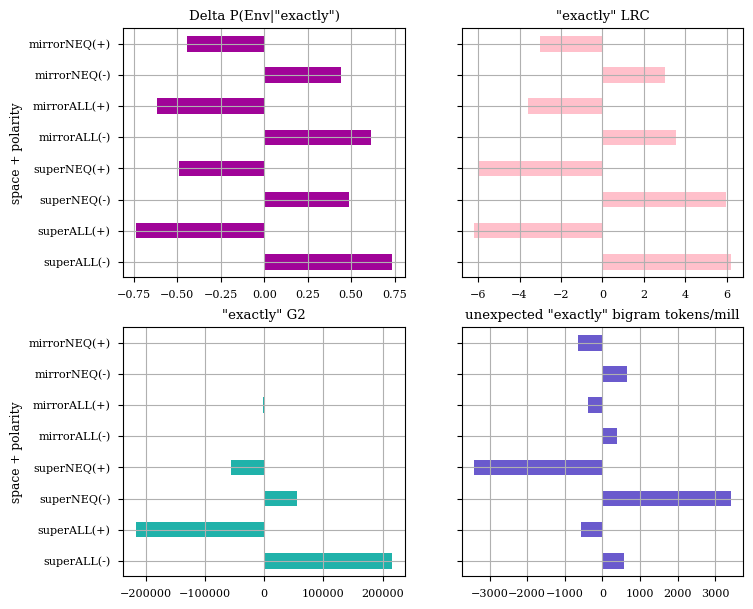

In [659]:

fig = _plot_df.filter(regex=r'dP|L|G|tpm_unexp_f$').plot(
    subplots=True, sharex=False, layout=(3, 2), sharey=True, legend=False,
    kind='barh', colormap='light_rain', grid=True, 
    figsize=(8, 11), fontsize=8, ylabel='space + polarity',
    title=['Delta P(Env|"exactly")', '"exactly" LRC', '"exactly" G2',
           'unexpected "exactly" bigram tokens/mill']
)
plt.savefig(IMAGE_DIR.joinpath(f'exactly/env~exactlyAM_subplots2x2_deltaP-LRC-G2-tpmUnexpF.{timestamp_today().replace("-","")}.png'), dpi=350, bbox_inches='tight', pad_inches=0.1)
if SHOW_FIGS:
    plt.show()

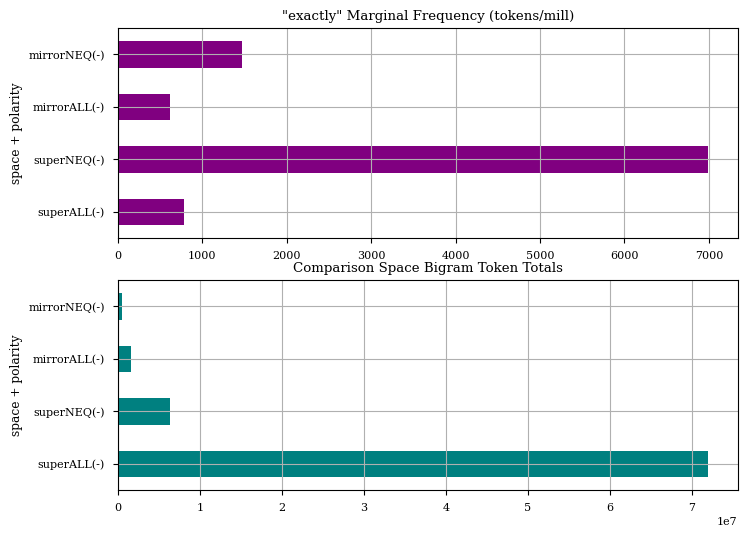

In [660]:
fig = _plot_df.filter(['tpm_f2', 'N']).drop_duplicates().plot(
    subplots=True, sharex=False, sharey=True, legend=False,
    kind='barh', colormap='little_mermaid', grid=True, figsize=(8, 6), 
    fontsize=8, ylabel='space + polarity',
    title=['"exactly" Marginal Frequency (tokens/mill)',
           'Comparison Space Bigram Token Totals']
)
plt.savefig(IMAGE_DIR.joinpath(f'exactly/env~exactlyF_subplots2x2.{timestamp_today().replace("-","")}.png'), 
dpi=350, bbox_inches='tight', pad_inches=0.1)


In [661]:
_plot_df_x = _plot_df.filter(['tpm_f', 'tpm_f1']).assign(
    space=_plot_df.index.str.strip(
        '(-+)').str.replace(r'r(?=[AN])', 'r ', regex=True),
    polarity=_plot_df.index.str[-3:]
).set_index(['space', 'polarity']).unstack()
_plot_df_x

tpm_f              tpm_f1           
polarity      (+)      (-)        (+)        (-)
space                                           
mirror ALL 129.71   483.75 826,413.62 173,586.38
mirror NEQ  83.98 1,393.39 500,000.00 500,000.00
super ALL  170.87   608.84 955,897.44  44,102.56
super NEQ   89.01 6,902.55 500,000.00 500,000.00

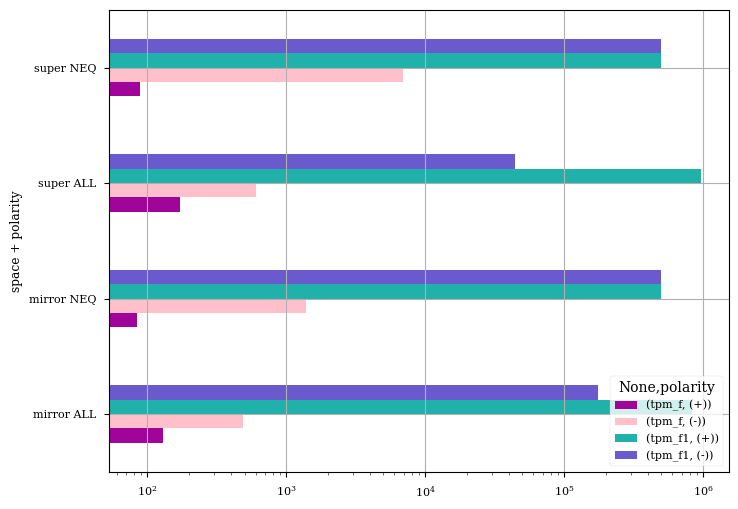

In [662]:

fig = _plot_df_x.plot(
    # subplots=True, 
    # legend=False,
    sharex=False, sharey=True, logx=True,
    kind='barh', colormap='light_rain', grid=True, 
    figsize=(8, 6), fontsize=8, ylabel='space + polarity',
    # title='[Env~"exactly" Joint Frequency (tokens/mill)', 'Env Marginal Frequency (tokens/mill)']
)

In [663]:
# plot_polar_f(exactly_df.unstack(), (7, 2.5), colormap_name='seismic',
#              image_dir=IMAGE_DIR, image_label='exactly')

Output Path: "/share/compling/projects/sanpi/info/writing_links/imports/images/exactly/exactly_fSqrt(+)-fSqrt(-)_20250107_01.png"
Output Path: "/share/compling/projects/sanpi/info/writing_links/imports/images/exactly/exactly_tpmFSqrt(+)-tpmFSqrt(-)_20250107_01.png"
Output Path: "/share/compling/projects/sanpi/info/writing_links/imports/images/exactly/exactly_unexpFSqrt(+)-unexpFSqrt(-)_20250107_01.png"


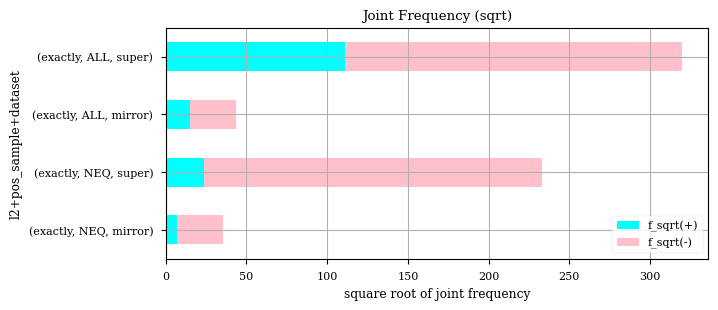

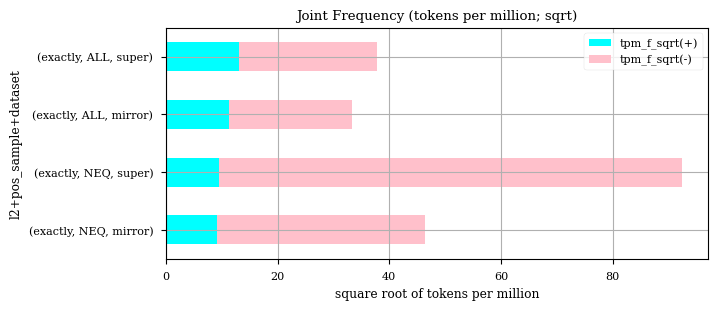

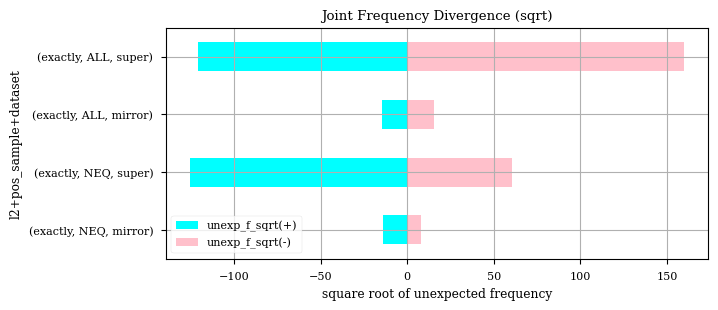

Output Path: "/share/compling/projects/sanpi/info/writing_links/imports/images/exactly/exactly_tpmUnexpFSqrt(+)-tpmUnexpFSqrt(-)_20250107_01.png"


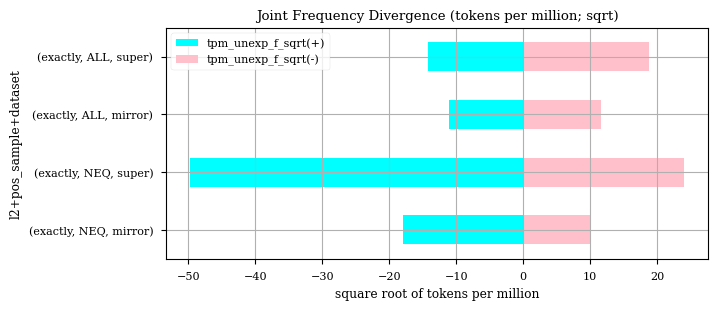

Output Path: "/share/compling/projects/sanpi/info/writing_links/imports/images/exactly/exactly_tpmUnexpFSqrt(+)-tpmFSqrt(+)-tpmFSqrt(-)-tpmUnexpFSqrt(-)_20250107_01.png"


Output Path: "/share/compling/projects/sanpi/info/writing_links/imports/images/exactly/exactly_unexpR(+)-unexpR(-)_20250107_01.png"


Output Path: "/share/compling/projects/sanpi/info/writing_links/imports/images/exactly/exactly_dP1(+)-dP1(-)_20250107_01.png"


Output Path: "/share/compling/projects/sanpi/info/writing_links/imports/images/exactly/exactly_LRC(+)-LRC(-)_20250107_01.png"


html formatted table saved as: "/share/compling/projects/sanpi/info/writing_links/imports/tables/polar-exactly_AM.by-['l2', 'dataset', 'pos_sample'].25-01-07_05.html"


In [664]:
viz_adv_polar('exactly', exactly_df.join(
    exactly_str_info).reset_index().set_index('space_key'),
    colormap_name='blue_black_pink', size_tuple=(7, 3))

Old table to replace...

|                      approximation evidence | attribute                        | *Absent Negative* (*E superset) |                            | *Present Positive* (@E subset) |                 |
|--------------------------------------------:|:---------------------------------|--------------------------------:|---------------------------:|-------------------------------:|----------------:|
|                                       total | **`amdf.N`**                     |                $^T$`86,330,752` |                            |  $^M$`2,032,082` ($_t$`2.35%`) |                 |
|                          *exactly* subtotal | **`amdf.f2`**                    |                    $^S$`61,599` |                            |      $^A$`1,114` ($_s$`1.81%`) |                 |
|                                 environment |                                  |              $*N^+$, `RBdirect` | $*C_{N^+}$, `not-RBdirect` |                @N, `NEGmirror` | @P, `POSmirror` |
|                        environment subtotal | **`amdf.f1`**                    |                     `3,226,213` |               `83,102,035` |                      `293,963` |     `1,738,105` |
|        environment % of set totals $^{T,M}$ | **`(amdf.f1/amdf.N)*100`**       |                     $_t$`3.74%` |               $_t$`96.26%` |                   $_m$`14.47%` |    $_m$`85.53%` |
|                    *observed other ADV $f$* | **`amdf.N - amdf.f2`**           |                 (*`3,182,578`*) |           (*`83,084,071`*) |                  (*`293,150`*) | (*`1,737,804`*) |
|                      **observed joint $f$** | **`amdf.f`**                     |                $^N$**`43,635`** |           $^C$**`17,964`** |                  $^X$**`813`** |   $^P$**`301`** |
|       % of set *exactly* subtotals $^{S,A}$ | **`(amdf.f/amdf.f2)*100`**       |                    $_s$`70.84%` |               $_s$`29.16%` |                   $_a$`72.98%` |    $_a$`27.02%` |
|       % of superset *exactly* subtotal $^S$ | **`(amdf.f/amdf.super_f2)*100`** |                               ^ |                          ^ |                    $_s$`1.32%` |     $_s$`0.49%` |
| % of same polarity superset tokens $^{N,C}$ | **`(amdf.f/amdf.super_f)*100`**  |                    ($_n$`100%`) |               ($_c$`100%`) |                    $_n$`1.86%` |     $_c$`1.68%` |
|                  total complement of subset | **`(amdf.N - amdf.mirror_N)`**   |                       `293,963` |               `81,363,930` |                          (`0`) |                 |
|              *exactly* complement of subset | **`(amdf.f2 - amdf.mirror_f2)`** |                        `42,822` |                    `17663` |                          (`0`) |                 |

👆 must be extended/replicated with both `ALL` and `NEQ` comparison spaces

In [665]:
xf = exactly_df.filter(regex=r'^[fN]\d?$').sort_index(axis=1)

super_xf = xf.copy().xs('super')
super_xf.columns.name = 'superset'
# super_xf = xf.filter(like='super',axis=0)
# set_my_style(super_xf.style)

mirror_xf = xf.copy().xs('mirror')
mirror_xf.columns.name = 'mirror subset'
# mirror_xf = xf.filter(like='mirror', axis=0)#
# set_my_style(mirror_xf.style)


xf = xf.assign(super_f=xf.index.to_series().apply(lambda x: super_xf.loc[x[1:], 'f']),
               super_f1=xf.index.to_series().apply(
                   lambda x: super_xf.loc[x[1:], 'f1']),
               super_f2=xf.index.to_series().apply(
                   lambda x: super_xf.loc[x[1:], 'f2']),
               mirror_f2=xf.index.to_series().apply(
                   lambda x: mirror_xf.loc[x[1:], 'f2']),
               mirror_N=xf.index.to_series().apply(
                   lambda x: mirror_xf.loc[x[1:], 'N']),
               super_N=xf.index.to_series().apply(
                   lambda x: super_xf.loc[x[1:], 'N']),
               )
tmp_cols = xf.filter(like='r_').columns.to_list()
print(tmp_cols)

# .rename(columns={'f2': 'f2=exactly_subtotal', 'f': 'f=joint_f',
#                  'f1': 'f1=env_subtotal', 'N': 'N=total'})
xf = (xf.assign(OTHER_joint_f=xf.f1-xf.f,
                # OTHER_subtotal=xf.N - xf.f2,
                N_pct_super_N=(xf.N / xf.super_N)*100,
                env_pct_N=(xf.f1 / xf.N) * 100,
                env_pct_super_N=(xf.f1/xf.super_N)*100,
                f_pct_f2=(xf.f / xf.f2) * 100,
                f_pct_super_f2=(xf.f / xf.super_f2)*100,
                f2_pct_super_f2=(xf.f2 / xf.super_f2)*100,
                f1_pct_super_f1=(xf.f1 / xf.super_f1)*100,
                f_pct_super_f=(xf.f / xf.super_f)*100,
                set_diff_f2=xf.f2 - xf.mirror_f2,
                set_diff_N=xf.N - xf.mirror_N,
                )
      .reset_index().set_index(['pos_sample', 'dataset', 'polarity']).sort_index(ascending=False)
      .drop(columns=tmp_cols))

set_my_style(xf.T.filter(like='ALL').style,
             index_font='iosevka ss07')

['super_f', 'super_f1', 'super_f2', 'mirror_f2', 'mirror_N', 'super_N']


In [666]:
set_my_style(xf.T.filter(like='NEQ').style,
             index_font='iosevka ss07')

In [667]:
all_xf = xf.sort_index(ascending=False).xs('ALL')
all_xf.columns.name = '`ALL+`'
print(all_xf.T.to_markdown(floatfmt=',.2f', intfmt=','))

| `ALL+`          |   ('super', 'pos') |   ('super', 'neg') |   ('mirror', 'pos') |   ('mirror', 'neg') |
|:----------------|-------------------:|-------------------:|--------------------:|--------------------:|
| N               |      71,961,373.00 |      71,961,373.00 |        1,680,633.00 |        1,680,633.00 |
| f               |          12,296.00 |          43,813.00 |              218.00 |              813.00 |
| f1              |      68,787,692.00 |       3,173,681.00 |        1,388,898.00 |          291,735.00 |
| f2              |          56,109.00 |          56,109.00 |            1,031.00 |            1,031.00 |
| OTHER_joint_f   |      68,775,396.00 |       3,129,868.00 |        1,388,680.00 |          290,922.00 |
| N_pct_super_N   |             100.00 |             100.00 |                2.34 |                2.34 |
| env_pct_N       |              95.59 |               4.41 |               82.64 |               17.36 |
| env_pct_super_N |              95.59 |      

In [668]:
neq_xf = xf.sort_index(ascending=False).xs('NEQ')
neq_xf.columns.name = '`NEQ+`'
print(neq_xf.T.to_markdown(floatfmt=',.2f', intfmt=','))

| `NEQ+`          |   ('super', 'pos') |   ('super', 'neg') |   ('mirror', 'pos') |   ('mirror', 'neg') |
|:----------------|-------------------:|-------------------:|--------------------:|--------------------:|
| N               |       6,347,362.00 |       6,347,362.00 |          583,470.00 |          583,470.00 |
| f               |             565.00 |          43,813.00 |               49.00 |              813.00 |
| f1              |       3,173,681.00 |       3,173,681.00 |          291,735.00 |          291,735.00 |
| f2              |          44,378.00 |          44,378.00 |              862.00 |              862.00 |
| OTHER_joint_f   |       3,173,116.00 |       3,129,868.00 |          291,686.00 |          290,922.00 |
| N_pct_super_N   |             100.00 |             100.00 |                9.19 |                9.19 |
| env_pct_N       |              50.00 |              50.00 |               50.00 |               50.00 |
| env_pct_super_N |              50.00 |      

In [669]:
set_my_style(
    xf.filter(like='pct')
    .T.style,
    index_font='iosevka ss07')

## Polar Propensities of *Exactly* Bigrams

### Load `env~bigram` data

In [24]:
polar_bigram_index = ['dataset', 'pos_sample', 'polarity', 'adj']
exactly_bigrams_csv = TOP_AM_DIR.joinpath(
    f'exactly/env~exactly_bigrams_compiled.csv')
exactly_bigrams_parq = exactly_bigrams_csv.with_suffix('.min0x.parq')

raw_exactly_bigrams = None
all_exactly_bigrams = None
if exactly_bigrams_parq.exists():
    all_exactly_bigrams = pd.read_parquet(
        exactly_bigrams_parq, engine='pyarrow')
    print(f'Loaded from prior parquet: "{exactly_bigrams_parq.relative_to(SANPI_HOME)}"')
elif exactly_bigrams_csv.is_file():
    all_exactly_bigrams = pd.reac_csv(exactly_bigrams_csv)
    print(f'Loaded from prior csv: "{exactly_bigrams_csv.relative_to(SANPI_HOME)}"')
else:
    all_exactly_bigrams = load_all_relevant_ams(
        {'exactly', }, unit='bigram', label='exactly')

    updated_eb = extend_freq_cols(all_exactly_bigrams)
    updated_eb = update_amdf(updated_eb, polar=True, frequencies=False)
    updated_eb = updated_eb.loc[:, updated_eb.count() == len(updated_eb)]
    updated_eb.loc[:, updated_eb.count() == len(updated_eb)].to_parquet(
        exactly_bigrams_parq, engine='pyarrow',
        partition_cols=['dataset', 'pos_sample'],
        basename_template='group-{i}.parquet',
        existing_data_behavior='delete_matching')
    if 'tpm_adj_total' not in updated_eb.columns:
        updated_eb['tpm_adj_total'] = tok_per_mill('adj_total', updated_eb)
    updated_eb.to_csv(exactly_bigrams_csv)
    all_exactly_bigrams = updated_eb
all_exactly_bigrams = all_exactly_bigrams.convert_dtypes()

if 'space_key' in all_exactly_bigrams.columns:
    all_exactly_bigrams = all_exactly_bigrams.set_index('space_key')

Loaded from prior parquet: "results/top_AM/exactly/env~exactly_bigrams_compiled.min0x.parq"


```log

+ ALL+sup
RBdirect/bigram/extra/polarized-bigram_ALL-direct_min1x_extra.parq

+ NEQ+sup
RBdirect/bigram/extra/polarized-bigram_NEQ-direct_min1x_extra.parq

+ NEQ+mir
mirror/bigram/extra/polarized-bigram_NEQ-mirror_min1x_extra.parq

+ ALL+mir
mirror/bigram/extra/polarized-bigram_ALL-mirror_min1x_extra.parq

<class 'pandas.core.frame.DataFrame'>
Index: 8961 entries, ALL+sup:NEG~exactly_conducive to ALL+sup:POS~exactly_surprising
Data columns (total 78 columns):
...
All env~exactly_* bigram AM info saved as "/share/compling/projects/sanpi/results/top_AM/exactly_bigrams_compiled.csv"
```
```log
+ ALL+sup
polar/RBdirect/bigram/extra/polarized-bigram_ALL-direct_min1x_extra.parq
  > exhaustive path (for target set)
    "polar/RBdirect/bigram/extra/polarized-bigram_ALL-direct_min0x-exactly_extra.parq"
  loading from prior exhaustive processing in "polar/RBdirect/bigram/extra/polarized-bigram_ALL-direct_min0x-exactly_extra.parq"

+ NEQ+sup
polar/RBdirect/bigram/extra/polarized-bigram_NEQ-direct_min1x_extra.parq
  > exhaustive path (for target set)
    "polar/RBdirect/bigram/extra/polarized-bigram_NEQ-direct_min0x-exactly_extra.parq"
  loading from prior exhaustive processing in "polar/RBdirect/bigram/extra/polarized-bigram_NEQ-direct_min0x-exactly_extra.parq"

+ NEQ+mir
polar/mirror/bigram/extra/polarized-bigram_NEQ-mirror_min1x_extra.parq
  > exhaustive path (for target set)
    "polar/mirror/bigram/extra/polarized-bigram_NEQ-mirror_min0x-exactly_extra.parq"
  loading from prior exhaustive processing in "polar/mirror/bigram/extra/polarized-bigram_NEQ-mirror_min0x-exactly_extra.parq"

+ ALL+mir
polar/mirror/bigram/extra/polarized-bigram_ALL-mirror_min1x_extra.parq
  > exhaustive path (for target set)
    "polar/mirror/bigram/extra/polarized-bigram_ALL-mirror_min0x-exactly_extra.parq"
  loading from prior exhaustive processing in "polar/mirror/bigram/extra/polarized-bigram_ALL-mirror_min0x-exactly_extra.parq"
```

#### Investigate Marginal Frequencies

> Filter to only bigrams exceeding a set floor

In [25]:
def describe_strings(_df):
    # print(f'Minimum joint frequency: {_df.f.min():,}')
    # print(f'Minimum MEAN joint frequency (by polarity): {_df.f_m.min():,}')
    print(f'Minimum bigram subtotal: {_df.f2.min():,}')
    print(f'Minimum MEAN bigram subtotal: {_df.f2_m.min():,}')
    print(f'{_df.l2.nunique():,} total unique "exactly ADJ" bigrams attested')
    return set_my_style(_df.select_dtypes('string').describe().T.convert_dtypes().style, index_font='')

describe_strings(all_exactly_bigrams)

Minimum bigram subtotal: 1
Minimum MEAN bigram subtotal: 0.25
3,995 total unique "exactly ADJ" bigrams attested


> 🚩 `exactly_bigrams` filtered to only adjectives with a corresponding _mean_ bigram per million subtotal (`tpm_f2_m`) which is at least equal to the **40th percentile** of the all bigram per million subtotals.

In [26]:
Q=0.4
quantile_tpm_f2_floor = all_exactly_bigrams[all_exactly_bigrams.f2 > 0].tpm_f2.quantile(Q)

print(all_exactly_bigrams.filter(regex=r'^[tpm_]*(f2)_?m?$').describe().filter(regex=r'[m\d]', axis=0).to_markdown(floatfmt=',.3f', intfmt=',', tablefmt='rounded_outline'))
print(f'bigram subtotal {str(Q).strip("0.")+("0" if len(str(Q))==3 else "")}th percentile = {quantile_tpm_f2_floor:.6f} (bigram tokens per million)')
# print(f'  {quantile_tpm_f2_floor * (10e6):,.0f} tokens')
# print((all_exactly_bigrams.copy().set_index('space')
#        .N.drop_duplicates().multiply(quantile_tpm_f2_floor))
#       .to_frame('percentile applied to each comparison space (N)').to_markdown(tablefmt='rounded_outline', floatfmt=',.3f'))



╭──────┬───────────┬───────────┬───────────┬────────────╮
│      │        f2 │    tpm_f2 │      f2_m │   tpm_f2_m │
├──────┼───────────┼───────────┼───────────┼────────────┤
│ mean │    12.219 │     1.177 │    10.379 │      1.027 │
│ min  │     1.000 │     0.014 │     0.250 │      0.003 │
│ 25%  │     1.000 │     0.014 │     0.500 │      0.043 │
│ 50%  │     1.000 │     0.158 │     1.000 │      0.086 │
│ 75%  │     4.000 │     0.472 │     2.500 │      0.300 │
│ max  │ 8,840.000 │ 1,385.930 │ 4,483.250 │    462.623 │
╰──────┴───────────┴───────────┴───────────┴────────────╯
bigram subtotal 40th percentile = 0.097274 (bigram tokens per million)


In [27]:

exactly_bigrams = all_exactly_bigrams.copy().loc[
    all_exactly_bigrams.f2_m >= 10, :]

# exactly_bigrams = all_exactly_bigrams.copy().loc[all_exactly_bigrams.tpm_f2_m >
#                                       quantile_tpm_f2_floor, :]
print('\n***\nAfter limiting based on bigram subtotals\n***')
print(exactly_bigrams.filter(regex=r'^[tpm_]*(f2)_?m?$').describe().filter(regex=r'[m\d]', axis=0).to_markdown(floatfmt=',.2f', intfmt=',', tablefmt='rounded_outline'))
describe_strings(exactly_bigrams)


***
After limiting based on bigram subtotals
***
╭──────┬──────────┬──────────┬──────────┬────────────╮
│      │       f2 │   tpm_f2 │     f2_m │   tpm_f2_m │
├──────┼──────────┼──────────┼──────────┼────────────┤
│ mean │    88.89 │     8.48 │    82.02 │       7.92 │
│ min  │     1.00 │     0.26 │    10.00 │       0.37 │
│ 25%  │     2.00 │     0.60 │    15.00 │       1.55 │
│ 50%  │    27.00 │     1.79 │    23.25 │       2.58 │
│ 75%  │    55.00 │     5.43 │    53.00 │       4.82 │
│ max  │ 8,840.00 │ 1,385.93 │ 4,483.25 │     462.62 │
╰──────┴──────────┴──────────┴──────────┴────────────╯
Minimum bigram subtotal: 1
Minimum MEAN bigram subtotal: 10.0
306 total unique "exactly ADJ" bigrams attested


In [28]:
format_zeros(
    show_example_l2(
        all_exactly_bigrams,
        example_l2=(all_exactly_bigrams
                    .loc[all_exactly_bigrams.f2_m >= 2, ['l2']]
                    .sample(1).squeeze()),
        index_order=['l2', 'dataset', 'pos_sample',
                     'adj_total', 'f2', 'direction', 'polarity'],
        columns=['adj_total', 'P1',  'dP1', 'LRC', 'f2', 'unexp_r'], transpose=True), zeros_opacity=30)

html table saved as
  "imports/tables/env~l2_examples/exactly_iconic/ENV~exactly_iconic_example-table.2025-01-07.html"


### Plot Adjective/Bigram Marginal Frequencies

#### Superset

##### ALL of Superset (Bigrams with *exactly*)

In [675]:
# plot_sequential_margins(all_exactly_bigrams, dataset='super')

##### NEQ Sample of Superset (Bigrams with *exactly*)

In [676]:
# plot_sequential_margins(all_exactly_bigrams, dataset='super', pos_sample='NEQ')

##### Restricted by Bigram Subtotal

mean bigram subtotal as `tpm_f2_m` $>$ 40th percentile of bigram subtotals `tpm_f2.quantile(0.4)`

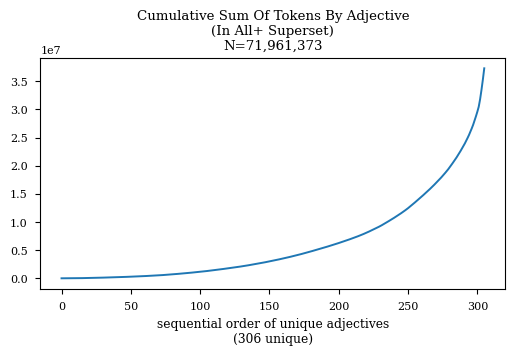

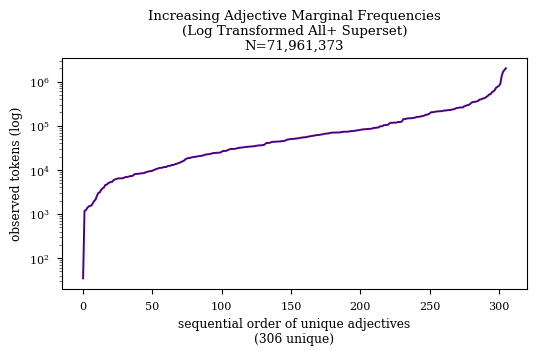

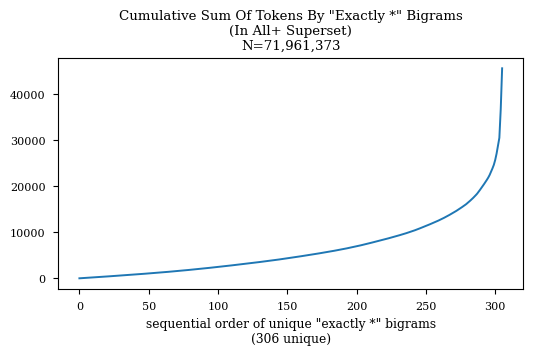

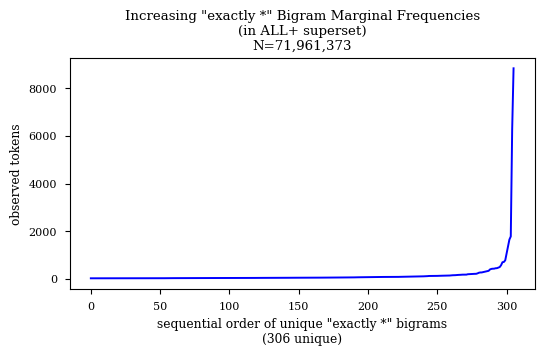

In [677]:
plot_sequential_margins(exactly_bigrams)

In [678]:
# plot_sequential_margins(all_exactly_bigrams, dataset='mirror')


# plot_sequential_margins(all_exactly_bigrams, dataset='mirror')

### Investigate Significance Rates of Polarity Sensitive Bigrams

In [29]:
all_exactly_bigrams = eval_sig(all_exactly_bigrams)
style_crosstab(all_exactly_bigrams, ['pos_sample', 'dataset',], ['direction','polarity'], 'adj', 
               aggfunc='count', sort=False, axis=None,
               group=True, cmap = 'BuPu', cmap2=None, cmap3=None,
               prefilter_label='ExactlyBigramsSignif')


formatted table saved as html: imports/tables/ExactlyBigramsSignif/pos_sample-dataset_adj-count_direction-polarity_color-table_grouped.2025-01-07_18.html


In [30]:
exactly_bigrams = eval_sig(exactly_bigrams)
style_crosstab(exactly_bigrams, ['pos_sample', 'dataset',], ['direction','polarity'], 'adj', 
               aggfunc='count', sort=False, axis=None,
               group=True, cmap = 'YlGnBu', cmap2=None, cmap3=None,
               prefilter_label='ExactlyBigramsSignif_f2Limited')

formatted table saved as html: imports/tables/ExactlyBigramsSignif_f2Limited/pos_sample-dataset_adj-count_direction-polarity_color-table_grouped.2025-01-07_18.html


In [31]:
#// signif_counts = get_sensitive_bigram_totals(all_exactly_bigrams)
#// sty = format_zeros(set_my_style(signif_counts.style
#//                    # f'✕ {sig_df.space.nunique()} spaces ✕ 2 polarities'
#//                    .background_gradient(subset=signif_counts.columns.to_list()[:4], 
#//                                         axis=None, cmap='GnBu', low=0.25,)
#//                    .background_gradient(subset=['total'], cmap='Blues', axis=0)
#//                    .background_gradient(subset=['ratio'], cmap='Greens', axis=0)
#//                    .highlight_between(left=-0.9, right=0.1, props='opacity:80%'), 
#//                    caption_side='bottom', caption_align='left',
#//                    caption=(
#//                        f'Polar sensitivities across {len(all_exactly_bigrams):,} evaluations:<br/>'
#//                        f'• <i>{all_exactly_bigrams.l2.nunique():,} unique "exactly" bigrams</i><br/>'
#//                        '• <i>minimum bigram subtotal = '
#//                        f'{all_exactly_bigrams.filter(like="ALL+sup", axis=0).f2.min()}</i>')
#//                    ))
#// save_html(sty,
save_html(display_sensitive_totals(all_exactly_bigrams), 
          f'DirectionalSignificance_FULL_MinF2={all_exactly_bigrams.f2.min()}_counts',
          'ExactlyBigramsSignif')

html table saved as
  "imports/tables/ExactlyBigramsSignif/DirectionalSignificance_FULL_MinF2=1_counts.2025-01-07.html"


In [32]:
save_html(display_sensitive_totals(exactly_bigrams), 
          f'DirectionalSignificance_MinF2mean={exactly_bigrams.f2_m.min():.0f}_counts',
          'ExactlyBigramsSignif')

html table saved as
  "imports/tables/ExactlyBigramsSignif/DirectionalSignificance_MinF2mean=10_counts.2025-01-07.html"


In [33]:
exactly_bigrams_limit = exactly_bigrams[exactly_bigrams.f2>=20]
# limit_signif_counts = get_sensitive_bigram_totals(exactly_bigrams_limit)

# sty = format_zeros(set_my_style(limit_signif_counts.style
#                    # f'✕ {sig_df.space.nunique()} spaces ✕ 2 polarities'
#                    .background_gradient(subset=limit_signif_counts.columns.to_list()[:4], 
#                                         axis=None, cmap='GnBu')
#                 #    .highlight_between(left=-0.9, right=0.1, props='opacity:80%')
#                    .background_gradient(subset=['total'], cmap='Blues', axis=0)
#                    .background_gradient(subset=['ratio'], cmap='Greens', axis=0),
#                    caption=(
#                        f'Polar sensitivities across {len(exactly_bigrams_limit):,} evaluations:<br/>'
#                        f'<i>{exactly_bigrams_limit.l2.nunique():,} unique "exactly" bigrams</i><br/>'
#                        f'<i>minimum bigram subtotal in any space = {exactly_bigrams_limit.f2.min()}</i><br/>'
#                        f'<i>minimum bigram subtotal in superset = {exactly_bigrams_limit.filter(like="ALL+sup", axis=0).f2.min()}</i>')
#                    ))

save_html(display_sensitive_totals(exactly_bigrams_limit), 
          f'DirectionalSignificance_MinF2={exactly_bigrams_limit.f2.min()}_counts',
          'ExactlyBigramsSignif')

html table saved as
  "imports/tables/ExactlyBigramsSignif/DirectionalSignificance_MinF2=20_counts.2025-01-07.html"


In [34]:
show_example_l2(all_exactly_bigrams, example_l2='exactly_sure', index_order=['l2', 'dataset', 'pos_sample', 'adj_total', 'f2', 'direction','polarity'], 
                columns=['adj_total','P1',  'dP1','LRC', 'f2', 'unexp_r'], transpose=True)

html table saved as
  "imports/tables/env~l2_examples/exactly_sure/ENV~exactly_sure_example-table.2025-01-07.html"


In [35]:
show_example_l2(all_exactly_bigrams, 'exactly_conducive',
                index_order=['l2', 'dataset', 'pos_sample', 'adj_total', 'f2', 'direction','polarity', 'f'], 
                columns=['adj_total','P1', 'dP1','LRC',  'f2','f', 'unexp_r'], transpose=True)

html table saved as
  "imports/tables/env~l2_examples/exactly_conducive/ENV~exactly_conducive_example-table.2025-01-07.html"


In [36]:
show_example_l2(all_exactly_bigrams, 'exactly_right',
                index_order=['l2', 'dataset', 'pos_sample', 'adj_total', 'f2', 'direction','polarity', 'f'], 
                columns=[ 'P1','adj_total', 'dP1','LRC', 'f2','f', 'unexp_r'], transpose=True)

html table saved as
  "imports/tables/env~l2_examples/exactly_right/ENV~exactly_right_example-table.2025-01-07.html"


In [37]:
show_example_l2(all_exactly_bigrams, 'exactly_fair',
                index_order=['l2', 'dataset', 'pos_sample', 'adj_total', 'f2', 'direction','polarity', 'f'], 
                columns=[ 'P1','adj_total', 'dP1','LRC', 'f2','f', 'unexp_r'], transpose=True)

html table saved as
  "imports/tables/env~l2_examples/exactly_fair/ENV~exactly_fair_example-table.2025-01-07.html"


In [38]:
show_example_l2(all_exactly_bigrams, 'exactly_late-career',
                index_order=['l2', 'dataset', 'pos_sample', 'adj_total', 'f2', 'direction','polarity', 'f'], 
                columns=[ 'P1','adj_total', 'dP1','LRC', 'f2','f', 'unexp_r'], transpose=True)

html table saved as
  "imports/tables/env~l2_examples/exactly_late-career/ENV~exactly_late-career_example-table.2025-01-07.html"


In [39]:
show_example_l2(all_exactly_bigrams, 'exactly_equal', columns=['P1', 'dP1', 'LRC', 'tpm_unexp_f', 'unexp_r'], 
                transpose=True,
                index_order = ['l2', 'dataset', 'pos_sample', 'adj_total', 'f2', 'direction', 'polarity'])

html table saved as
  "imports/tables/env~l2_examples/exactly_equal/ENV~exactly_equal_example-table.2025-01-07.html"


In [40]:
show_example_l2(all_exactly_bigrams, 'exactly_cheap',
                columns=['P1', 'dP1', 'LRC', 'tpm_unexp_f', 'unexp_r'], 
                transpose=True,
                index_order = ['l2', 'dataset', 'pos_sample', 'adj_total', 'f2', 'direction', 'polarity'])

html table saved as
  "imports/tables/env~l2_examples/exactly_cheap/ENV~exactly_cheap_example-table.2025-01-07.html"


In [41]:
show_example_l2(all_exactly_bigrams, 'exactly_identical',
                 columns=['P1', 'dP1', 'LRC', 'tpm_unexp_f', 'unexp_r'], 
                transpose=True,
                index_order = ['l2', 'dataset', 'pos_sample', 'adj_total', 'f2', 'direction', 'polarity'])

html table saved as
  "imports/tables/env~l2_examples/exactly_identical/ENV~exactly_identical_example-table.2025-01-07.html"


In [42]:
pos_lean_bigrams = (all_exactly_bigrams
                    .loc[(all_exactly_bigrams.dP1m > 0) & (all_exactly_bigrams.f2_m > 2)]
                    .filter(like='POS', axis=0))
pos_lean_bigrams.value_counts(['adj', 'f2_m', 'dP1m', 'LRCm']).to_frame().sort_index(level=['LRCm', 'dP1m']).reset_index(['dP1m', 'LRCm']).droplevel('f2_m')

dP1m  LRCm  count
adj                           
enough       0.06 -0.16      4
overhead     0.01  0.00      1
conjunct     0.01  0.00      1
halfway      0.01  0.00      1
more         0.04  0.00      3
divisible    0.04  0.00      2
counter      0.14  0.00      2
midnight     0.14  0.00      2
equidistant  0.14  0.00      2
most         0.14  0.00      2
backward     0.14  0.00      2
contrary     0.18  0.00      3
opposite     0.20  0.00      4

In [43]:
show_example_l2(all_exactly_bigrams, 'exactly_contrary',
                 columns=['P1', 'dP1',  'LRC', 'tpm_unexp_f', 'unexp_r'], 
                transpose=True, precision=2,
                index_order = ['l2', 'dataset', 'pos_sample', 'adj_total', 'f2', 'direction', 'polarity'])

html table saved as
  "imports/tables/env~l2_examples/exactly_contrary/ENV~exactly_contrary_example-table.2025-01-07.html"


In [44]:
show_example_l2(all_exactly_bigrams, pos_lean_bigrams.drop_duplicates('l2').sample(1).l2.squeeze(),
                 columns=['P1', 'dP1', 'LRC', 'tpm_unexp_f', 'unexp_r'], 
                transpose=True, precision=2,
                index_order = ['l2', 'dataset', 'pos_sample', 'adj_total', 'f2', 'direction', 'polarity'])

html table saved as
  "imports/tables/env~l2_examples/exactly_midnight/ENV~exactly_midnight_example-table.2025-01-07.html"


### Visualize polar sensitivity by marginal frequency bins

In [695]:
freq_cols = ['f','f_m','f2','f2_m','adj_total','tpm_f', 'tpm_f_m','tpm_f2', 'tpm_f2_m','tpm_adj_total']
all_exactly_bq = all_exactly_bigrams.copy().filter(COLUMN_LIST+['direction', 'LRC!=0'] + freq_cols)
for freq_col in freq_cols:
    all_exactly_bq = designate_bins(all_exactly_bq, freq_col)


##### `f2_quantile_info`

In [696]:
style_crosstab(all_exactly_bq.assign(direction=all_exactly_bq.direction.astype('string'))
               .filter(like='NEG', axis=0),
               ['f2_quantile_info', ],['polarity','direction','dataset','pos_sample'],   
               value_col='adj', aggfunc='count', 
               axis=None, group=True, group_col='direction',
               cmap='PuRd', cmap2='bone_r',
               prefilter_label='neg_exactly-bigrams_significance', sort=False, index_font='')

formatted table saved as html: imports/tables/neg_exactly-bigrams_significance/f2_quantile_info_adj-count_polarity-direction-dataset-pos_sample_color-table_grouped.2025-01-07_01.html


##### `f2_m_quantile_info`

In [697]:
style_crosstab(all_exactly_bq.assign(direction=all_exactly_bq.direction.astype('string'))
               .filter(like='NEG', axis=0),
               ['f2_m_quantile_info', ],['polarity','direction','dataset','pos_sample'],   
               value_col='adj', aggfunc='count', 
               axis=None, group=True, group_col='direction',
               cmap='PuRd', cmap2='bone_r',
               prefilter_label='neg_exactly-bigrams_significance', sort=False, index_font='')

formatted table saved as html: imports/tables/neg_exactly-bigrams_significance/f2_m_quantile_info_adj-count_polarity-direction-dataset-pos_sample_color-table_grouped.2025-01-07_01.html


##### `tpm_f2_quantile_info`

In [698]:
style_crosstab(all_exactly_bq.assign(direction=all_exactly_bq.direction.astype('string'))
               .filter(like='NEG', axis=0),
               ['tpm_f2_quantile_info', ],['polarity','direction','dataset','pos_sample'],   
               value_col='adj', aggfunc='count', 
               axis=None, group=True, group_col='direction',
               cmap='PuRd', cmap2='bone_r',
               prefilter_label='neg_exactly-bigrams_significance', sort=False, index_font='')

formatted table saved as html: imports/tables/neg_exactly-bigrams_significance/tpm_f2_quantile_info_adj-count_polarity-direction-dataset-pos_sample_color-table_grouped.2025-01-07_01.html


##### `tpm_f2_m_quantile_info`

In [699]:
style_crosstab(all_exactly_bq.assign(direction=all_exactly_bq.direction.astype('string'))
               .filter(like='NEG', axis=0),
               ['tpm_f2_m_quantile_info', ],['polarity','direction','dataset','pos_sample'],   
               value_col='adj', aggfunc='count', 
               axis=None, group=True, group_col='direction',
               cmap='PuRd', cmap2='bone_r',
               prefilter_label='neg_exactly-bigrams_significance', sort=False, index_font='')

formatted table saved as html: imports/tables/neg_exactly-bigrams_significance/tpm_f2_m_quantile_info_adj-count_polarity-direction-dataset-pos_sample_color-table_grouped.2025-01-07_01.html


##### `f_quantile_info`

In [700]:
style_crosstab(all_exactly_bq.assign(direction=all_exactly_bq.direction.astype('string'))
               .filter(like='NEG', axis=0),
               ['f_quantile_info', ],['polarity','direction','dataset','pos_sample'],   
               value_col='adj', aggfunc='count', 
               axis=None, group=True, group_col='direction',
               cmap='PuRd', cmap2='bone_r',
               prefilter_label='neg_exactly-bigrams_significance', sort=False, index_font='')

formatted table saved as html: imports/tables/neg_exactly-bigrams_significance/f_quantile_info_adj-count_polarity-direction-dataset-pos_sample_color-table_grouped.2025-01-07_01.html


##### `tpm_f_quantile_info`

In [701]:
style_crosstab(all_exactly_bq.assign(direction=all_exactly_bq.direction.astype('string'))
               .filter(like='NEG', axis=0),
               ['tpm_f_quantile_info', ],['polarity','direction','dataset','pos_sample'],   
               value_col='adj', aggfunc='count', 
               axis=None, group=True, group_col='direction',
               cmap='PuRd', cmap2='bone_r',
               prefilter_label='neg_exactly-bigrams_significance', sort=False, index_font='')

formatted table saved as html: imports/tables/neg_exactly-bigrams_significance/tpm_f_quantile_info_adj-count_polarity-direction-dataset-pos_sample_color-table_grouped.2025-01-07_01.html


##### `f_m_quantile_info`

In [702]:
style_crosstab(all_exactly_bq.assign(direction=all_exactly_bq.direction.astype('string'))
               .filter(like='NEG', axis=0),
               ['f_m_quantile_info', ],['polarity','direction','dataset','pos_sample'],   
               value_col='adj', aggfunc='count', 
               axis=None, group=True, group_col='direction',
               cmap='PuRd', cmap2='bone_r',
               prefilter_label='neg_exactly-bigrams_significance', sort=False, index_font='')

formatted table saved as html: imports/tables/neg_exactly-bigrams_significance/f_m_quantile_info_adj-count_polarity-direction-dataset-pos_sample_color-table_grouped.2025-01-07_01.html


##### `adj_total_quantile_info`

In [703]:
style_crosstab(all_exactly_bq.assign(direction=all_exactly_bq.direction.astype('string'))
               .filter(like='NEG', axis=0),
               ['adj_total_quantile_info', ], ['polarity','direction','dataset','pos_sample'],  
               value_col='adj', aggfunc='count', 
               axis=None, group=True, group_col='direction',
               cmap='BuGn',cmap2='GnBu',
               prefilter_label='neg_exactly-bigrams_significance', sort=False, index_font='')

formatted table saved as html: imports/tables/neg_exactly-bigrams_significance/adj_total_quantile_info_adj-count_polarity-direction-dataset-pos_sample_color-table_grouped.2025-01-07_01.html


In [704]:
style_crosstab(all_exactly_bq.assign(direction=all_exactly_bq.direction.astype('string'))
               .filter(like='NEG', axis=0),
               ['tpm_adj_total_quantile_info', ], ['direction','dataset','pos_sample'],  
               value_col='adj', aggfunc='count', 
               axis=None, group=True, 
               cmap='BuGn',cmap2='GnBu',
               prefilter_label='neg_exactly-bigrams_significance', sort=False, index_font='')

formatted table saved as html: imports/tables/neg_exactly-bigrams_significance/tpm_adj_total_quantile_info_adj-count_direction-dataset-pos_sample_color-table_grouped.2025-01-07_01.html


##### Total Significance by Quantiles

In [705]:
style_crosstab(all_exactly_bq.assign(direction=all_exactly_bq.direction.astype('string'))
               .filter(like='NEG', axis=0),
               ['f2_quantile_info'],['polarity','direction'],   
               value_col='adj', aggfunc='count',
               axis=None, group=True, group_col='direction',
               cmap='PuRd', cmap2='bone_r',
               prefilter_label='neg_exactly-bigrams_significance', sort=False, index_font=''
               )

formatted table saved as html: imports/tables/neg_exactly-bigrams_significance/f2_quantile_info_adj-count_polarity-direction_color-table_grouped.2025-01-07_01.html


In [706]:
style_crosstab(all_exactly_bq.assign(direction=all_exactly_bq.direction.astype('string'))
               .filter(like='NEG', axis=0),
               ['adj_total_quantile_info'],['polarity','direction'],   
               value_col='adj', aggfunc='count',
               axis=None, group=True, group_col='direction',
               cmap='BuGn',cmap2='GnBu',
               prefilter_label='neg_exactly-bigrams_significance', sort=False, index_font=''
               )

formatted table saved as html: imports/tables/neg_exactly-bigrams_significance/adj_total_quantile_info_adj-count_polarity-direction_color-table_grouped.2025-01-07_01.html


In [707]:
style_crosstab(all_exactly_bq.assign(direction=all_exactly_bq.direction.astype('string'))
               .filter(like='NEG', axis=0),
               ['f_m_quantile_info'],['polarity','direction'],   
               value_col='adj', aggfunc='count',
               axis=None, group=True, group_col='direction',
               cmap='PuRd', cmap2='bone_r',
               prefilter_label='neg_exactly-bigrams_significance', sort=False, index_font=''
               )

formatted table saved as html: imports/tables/neg_exactly-bigrams_significance/f_m_quantile_info_adj-count_polarity-direction_color-table_grouped.2025-01-07_01.html


In [708]:
style_crosstab(all_exactly_bq.assign(direction=all_exactly_bq.direction.astype('string'))
               .filter(like='NEG', axis=0),
               ['tpm_adj_total_quantile_info', ], [
                   'direction', 'dataset', 'pos_sample'],
               value_col='adj', aggfunc='count',
               axis=None, group=True,
               cmap='BuGn', cmap2='GnBu',
               prefilter_label='neg_exactly-bigrams_significance', 
               sort=False, index_font='')

formatted table saved as html: imports/tables/neg_exactly-bigrams_significance/tpm_adj_total_quantile_info_adj-count_direction-dataset-pos_sample_color-table_grouped.2025-01-07_01.html


#### direction of significance + `adj_total` quantiles by `f2` quantiles

In [709]:
style_crosstab(
    (all_exactly_bq.filter(like='ALL+sup:NEG', axis=0)
     .assign(direction=all_exactly_bq.direction.astype('string'))),
    ['direction', 'adj_total_quantile_info'], 
    ['f2_quantile_info',],
    value_col='adj', aggfunc='count',
    cmap='BuPu', index_font='', 
    cmap2='bone_r',
    #    cmap='green_kw9_smoothie_r',
    axis=None, group=False,
    prefilter_label='neg-ALL-super_exactly-bigrams_significance', sort=False)

formatted table saved as html: imports/tables/neg-ALL-super_exactly-bigrams_significance/direction-adj_total_quantile_info_adj-count_f2_quantile_info_color-table.2025-01-07_01.html


#### direction of significance + `f2` quantiles by `f_m` quantiles

In [710]:
style_crosstab(
    (all_exactly_bq.filter(like='ALL+sup:NEG', axis=0)
     .assign(direction=all_exactly_bq.direction.astype('string'))),
    ['direction','f2_quantile_info'], 
    [ 'f_m_quantile_info',],
    value_col='adj', aggfunc='count',
    cmap='BuPu', index_font='',
    cmap2='bone_r',
    #    cmap='green_kw9_smoothie_r',
    axis=None, group=False,
    prefilter_label='neg-ALL-super_exactly-bigrams_significance', sort=False)

formatted table saved as html: imports/tables/neg-ALL-super_exactly-bigrams_significance/direction-f2_quantile_info_adj-count_f_m_quantile_info_color-table.2025-01-07_01.html


#### direction of significance + `tpm_adj_total` quantiles by `tpm_f2` quantiles

In [711]:
style_crosstab(
    (all_exactly_bq.filter(like='ALL+sup:NEG', axis=0)
     .assign(direction=all_exactly_bq.direction.astype('string'))),
    ['direction', 'tpm_adj_total_quantile_info'], 
    ['tpm_f2_quantile_info',],
    value_col='adj', aggfunc='count',
    cmap='BuPu', index_font='',
    #    cmap='green_kw9_smoothie_r',
    axis=None, group=False,
    prefilter_label='neg-ALL-super_exactly-bigrams_significance', sort=False)

formatted table saved as html: imports/tables/neg-ALL-super_exactly-bigrams_significance/direction-tpm_adj_total_quantile_info_adj-count_tpm_f2_quantile_info_color-table.2025-01-07_01.html


In [712]:
exactly_bigrams = eval_sig(exactly_bigrams)
exactly_bigrams = designate_bins(exactly_bigrams, 'f2')
exactly_bigrams = designate_bins(exactly_bigrams, 'adj_total')

In [713]:
style_crosstab(exactly_bigrams.assign(direction=exactly_bigrams.direction.astype('string'))
               .filter(like='NEG', axis=0),
               ['f2_quantile_info', ],['polarity','direction','dataset','pos_sample'],   
               value_col='adj', aggfunc='count', 
               axis=None, group=True, group_col='direction',
               cmap='BuPu',cmap2='bone_r',
               prefilter_label='neg_exactly-bigrams_f2-restricted_signif', sort=False, index_font='')

formatted table saved as html: imports/tables/neg_exactly-bigrams_f2-restricted_signif/f2_quantile_info_adj-count_polarity-direction-dataset-pos_sample_color-table_grouped.2025-01-07_01.html


### Identify Most Polarity Sensitive *exactly* bigrams

In [45]:
exactly_bigrams['f2_max'] = exactly_bigrams.adj.map(
        all_exactly_bigrams[['adj','f2']].groupby('adj').max().squeeze())

<style>
    green {color: green;}
</style>
📌 **Note**  
To be considered as a top "polar sensitive" pairing ADJ, \
the <green>maximum bigram subtotal (i.e. superset ALL `f2`) must be at least **<u>50 tokens</u>**</green>

In [48]:
eval_metrics = ['dP1m', 'LRCm']
# eval_metrics = ['dP1m', 'LRCm', 'G2m']
adj_m = (exactly_bigrams
         .loc[(exactly_bigrams.f2_max >= 50), :]
         .loc[exactly_bigrams.direction != 'insignif', :]
         .drop_duplicates('polar_l2')
         .set_index(['polarity', 'adj'])
         .filter(regex=r'[m]$'))
adj_m[eval_metrics + ['f2_m']].describe()

dP1m   LRCm     f2_m
count 252.00 252.00   252.00
mean    0.00   0.00   138.95
std     0.58   2.34   439.30
min    -0.70  -7.10    20.75
25%    -0.68  -2.14    36.25
50%    -0.00   0.00    49.88
75%     0.68   2.14    87.00
max     0.70   7.10 4,483.25

In [53]:
bigram_skews = pd.DataFrame(adj_m.round(3).nlargest(13, pd.Series([m]+ eval_metrics).drop_duplicates())[m]
                     for m in eval_metrics).T
adj_in_sensitive_bigrams = bigram_skews.index.get_level_values('adj').to_series().drop_duplicates()

bigram_skews = bigram_skews.reset_index(level='polarity').assign(
    f2_m = adj_m.loc[bigram_skews.index, 'f2_m'].to_list(),
    f2_max=bigram_skews.index.get_level_values('adj').to_series().map(
        all_exactly_bigrams[['adj','f2']].groupby('adj').max().squeeze()),
    # f2_min=bigram_skews.index.get_level_values('adj').to_series().map(
    #     all_exactly_bigrams[['adj','f2']].groupby('adj').min().squeeze()),
    # adj_total_max=bigram_skews.index.get_level_values('adj').to_series().map(
    #     all_exactly_bigrams[['adj','adj_total']].groupby('adj').max().squeeze()),
    # adj_total_min=bigram_skews.index.get_level_values('adj').to_series().map(
    #     all_exactly_bigrams[['adj','adj_total']].groupby('adj').min().squeeze())
    )
bigram_skews = bigram_skews.sort_values('f2_m', ascending=False).reset_index().set_index(['polarity','adj']).head(25)

display(format_zeros(format_negatives(set_my_style(
    bigram_skews.convert_dtypes(), precision=3,
    caption = ('<b>25 Most Polarity Sensitive Adjectives<br/>'
                 'under <i>Exactly</i> Modification</b><br/>'
                 '<i>selected by the polar mean of each metric<br/>'
                 'and sorted by the maximum bigram subtotal (<code>f2</code>)</i>')
    ).background_gradient('RdPu'))))

top_polar_adj = list(bigram_skews.index.get_level_values('adj'))
TOP_POLAR_ADJ_PATH.write_text('\n'.join(top_polar_adj), encoding='utf8')
print(f'Top Polar Adjective selection saved as\n  "{TOP_POLAR_ADJ_PATH}"')

Top Polar Adjective selection saved as
  "/share/compling/projects/sanpi/results/top_AM/top25_exactly_polar_adj.txt"


In [112]:
save_html(set_my_style(
    (all_exactly_bigrams.filter(like=':NEG~', axis=0).loc[
        (all_exactly_bigrams.adj.isin(top_polar_adj)),
        ['polarity', 'adj', 'LRCm', 'dP1m', 'P1m', 'G2m','f_m', 'f2_m']
    ].set_index(['polarity', 'adj'])
     .drop_duplicates()#.stack().unstack(['polarity',-1])
     .sort_values('LRCm', ascending=False)
     .assign(rank=range(1,K+1))
     .reset_index()
    #  .rename(columns={'deltaP_mean': '∆P avg', 
    #                 #   'index':'rank',
    #                 'LRCm': 'mean<br/>LRC',
    #                 'unexp_r_m': 'mean<br/>unexpected/observed<br/>tokens ratio',
    #                  'dP1m':'mean<br/>backwards<br/>∆P',
    #                  'P1m':'mean<br/>backwards<br/>P',
    #                  'G2m':'mean<br/>G²',
    #                  'f_m':'mean<br/>joint<br/>frequency',
    #                  'f2_m':'mean<br/>bigram<br/>subtotal',
    #                 #  'dP2':'∆P(ADJ|x)',
    #                 #  'P2':'P(ADJ|x)',
    #                  'adj':'ADJ'})
    .set_index(['polarity', 'rank', 'adj'])
     ), precision=3,
    caption = (f'Top {K} Most Polarity Sensitive <i>Exactly</i> <code>ADJ</code> Bigrams<br/>'
               'selected by cross-space means of<br/>&nbsp;LRC (<code>LRCm</code>) & backwards delta P (<code>dP1m</code>)'),
    index_font='CMU classical serif').background_gradient('YlGn', axis=0),
          stem='TopPolarExactlyADJ_meanAMs', subdir='exactly-bigrams')

html table saved as
  "imports/tables/exactly-bigrams/TopPolarExactlyADJ_meanAMs.2025-01-07.html"


In [31]:
polar_skewed_bigram_adj = bigram_skews.index.get_level_values('adj').to_series().reset_index(drop=True)
polar_skewed_bigram_adj.index += 1
set_my_style(polar_skewed_bigram_adj.to_frame('Adjectives Most Polar Sensitive<br/>under Exactly Modification<br/>(<i>descending marginal frequency <code>f2</code></i>)')
             .style, data_font='CMU classical serif', 
             index_font='CMU bright', col_font='cmu bright')

In [32]:
try:
    all_exactly_bigrams = all_exactly_bigrams.assign(
        tpm_f2_m_quantile=all_exactly_bq.tpm_f2_m_quantile
    )
except NameError: 
    pass
skewed_bigrams = all_exactly_bigrams.loc[all_exactly_bigrams.adj.isin(polar_skewed_bigram_adj), :]

sty = set_my_style(
    skewed_bigrams.reset_index().drop_duplicates(
        'adj').set_index(all_exactly_bigrams.filter(['polarity', 'tpm_f2_m_quantile', 'adj']).columns.to_list())
    .filter(regex=r'([PGR][\dC]|(^(unexp_f|f2?)_))m$').sort_values('LRCm', ascending=False).sort_index(axis=1)
    .round(2).stack().unstack(['polarity', -1]),
    precision=2
).background_gradient(cmap='gnuplot2', high=0.1, low=0.02).set_caption(
    '<b>25 Most Polarity Sensitive Adjectives under <i>Exactly</i> Modification</b><br/>'
    + 'sorted by polar mean LRC (<code>LRCm</code>)</i>')
save_html(
    sty, f'25mostPolarSensitive_meanAM-f_color_{timestamp_today()}.html', 'ExactlyBigrams_skewed')
# _html_out = SANPI_HOME.joinpath(
#     f'info/writing_links/imports/tables/ExactlyBigrams/25mostPolarSensitive_meanAM-f_color_{timestamp_today()}.html')
# sty.to_html(_html_out)
# print(f'Stylized table saved as:\n  "{_html_out.relative_to(WRITING_LINKS)}"')
sty

html table saved as
  "imports/tables/ExactlyBigrams_skewed/25mostPolarSensitive_meanAM-f_color_2025-01-07.html.2025-01-07.html"


In [33]:
style_crosstab(skewed_bigrams,
               ['adj'],
               ['dataset', 'pos_sample','polarity'],
               sort_col_vals=('super', 'ALL', 'neg'),
               value_col='f',
            #    group=False,
               axis=0,
               cmap='CMRmap', mark_zeros=True,
               aggfunc='mean',
               prefilter_label='ExactlyBigrams_skewed')

formatted table saved as html: imports/tables/ExactlyBigrams_skewed/adj_f-mean_dataset-pos_sample-polarity_color-table.2025-01-07_17.html


In [34]:
style_crosstab(skewed_bigrams,
               ['adj'],
               ['dataset', 'pos_sample'],
               sort_col_vals=('super', 'ALL'),
               value_col='f2',
            #    group=False,
               axis=0, precision=1,
               cmap='ocean_r', 
               mark_zeros=True,
               aggfunc='mean',
               prefilter_label='ExactlyBigrams_skewed')

formatted table saved as html: imports/tables/ExactlyBigrams_skewed/adj_f2-mean_dataset-pos_sample_color-table.2025-01-07_17.html


In [35]:
style_crosstab(skewed_bigrams.loc[skewed_bigrams.polarity == 'neg'],
               ['adj', 'LRCm'],
               ['polarity', 'dataset','pos_sample'],
               sort_col_vals=('neg', 'super', 'ALL'),
               value_col='LRC',
               group=False,
               axis=None,
               cmap='BrBG',
               aggfunc='mean', index_font = '',
               prefilter_label='ExactlyBigrams_skewed-Neg-only')

formatted table saved as html: imports/tables/ExactlyBigrams_skewed-Neg-only/adj-LRCm_LRC-mean_polarity-dataset-pos_sample_color-table.2025-01-07_17.html


In [36]:
style_crosstab(skewed_bigrams[skewed_bigrams.polarity=='neg'],
               ['adj', 'dP1m'],
               ['polarity', 'dataset','pos_sample'],
               sort_col_vals=('neg', 'super', 'ALL'),
               value_col='dP1',
               group=True, group_col='pos_sample',
               axis=None,
               cmap='anastasia', cmap2=None,
               aggfunc='mean', index_font='',
               prefilter_label='ExactlyBigrams_skewed-Neg-only')

formatted table saved as html: imports/tables/ExactlyBigrams_skewed-Neg-only/adj-dP1m_dP1-mean_polarity-dataset-pos_sample_color-table_grouped.2025-01-07_17.html


In [37]:
# style_crosstab(skewed_bigrams,
#                ['adj'],
#                ['polarity', 'dataset','pos_sample'],
#                sort_col_vals=('neg', 'super', 'ALL'),
#                value_col='P1',
#                group=True, group_col='pos_sample', cmap2=None,
#                axis=None,
#                cmap='RdYlBu_r',
#                aggfunc='mean', precision=4,
#                prefilter_label='ExactlyBigrams_skewed')

In [38]:
adj_in_sensitive_bigrams = exactly_bigrams.loc[exactly_bigrams.LRC >0.1, ['adj', 'LRC', 'dP1']]
adj_in_sensitive_bigrams.join(adj_in_sensitive_bigrams.rank(), rsuffix='_rank')

adj  LRC  dP1  adj_rank  LRC_rank  dP1_rank
space_key                                                                  
ALL+mir:NEG~exact...           sure 5.58 0.83    448.50    418.00    267.00
ALL+mir:NEG~exact...          clear 3.94 0.83     60.50    266.00    266.00
ALL+mir:NEG~exact...           easy 2.22 0.83    119.00    183.00    265.00
ALL+mir:NEG~exact...  revolutionary 0.34 0.83    369.00     22.00    264.00
ALL+mir:NEG~exact...            new 2.61 0.79    280.50    194.00    259.00
...                             ...  ...  ...       ...       ...       ...
NEQ+sup:NEG~exact...      identical 0.97 0.41    218.50     93.00     19.00
NEQ+sup:NEG~exact...          wrong 1.56 0.40    525.00    137.00     18.00
NEQ+sup:NEG~exact...          alike 0.75 0.32     12.00     65.00     16.00
NEQ+sup:NEG~exact...          equal 0.13 0.30    135.50      2.00     14.00
NEQ+sup:NEG~exact...          right 0.82 0.22    374.00     76.00      8.00

[528 rows x 6 columns]

In [39]:
style_crosstab(exactly_bigrams[exactly_bigrams.LRCm>0.05],
               ['adj', 'LRCm'],
               ['polarity','dataset', 'pos_sample'],
            #    sort=False,
               sort_col_vals=[('neg','mirror', 'ALL'), ('neg', 'super', 'ALL')],
               value_col='LRC',
               group=False,
               axis=None, index_font='',
               prefilter_label='exactly-bigrams_attract-only',
               cmap='purple_rain',
               aggfunc='mean')

formatted table saved as html: imports/tables/exactly-bigrams_attract-only/adj-LRCm_LRC-mean_polarity-dataset-pos_sample_color-table.2025-01-07_17.html


In [40]:
style_crosstab(skewed_bigrams,
               ['adj'],
               ['dataset','polarity'],
               sort_col_vals=('super', 'neg'),
               value_col='LRC',
               group=True,
               axis=None,
            #    cmap='purple_teal',
               aggfunc='mean', precision=2,
               prefilter_label='ExactlyBigrams_skewed')

formatted table saved as html: imports/tables/ExactlyBigrams_skewed/adj_LRC-mean_dataset-polarity_color-table_grouped.2025-01-07_17.html


In [41]:
style_crosstab(skewed_bigrams,
               ['adj'],
               ['dataset','polarity'],
               sort_col_vals=('super', 'neg'),
               value_col='dP1',
               group=True,
               axis=None,
               cmap='lisa_frank',
               aggfunc='mean', precision=4,
               prefilter_label='ExactlyBigrams_skewed')

formatted table saved as html: imports/tables/ExactlyBigrams_skewed/adj_dP1-mean_dataset-polarity_color-table_grouped.2025-01-07_17.html


#### Specific Examples of Polarity Sensitive *exactly* bigrams

In [42]:
show_example_l2(skewed_bigrams)

html table saved as
  "imports/tables/env~l2_examples/exactly_true/ENV~exactly_true_example-table.2025-01-07.html"


### Bigram Visualizations

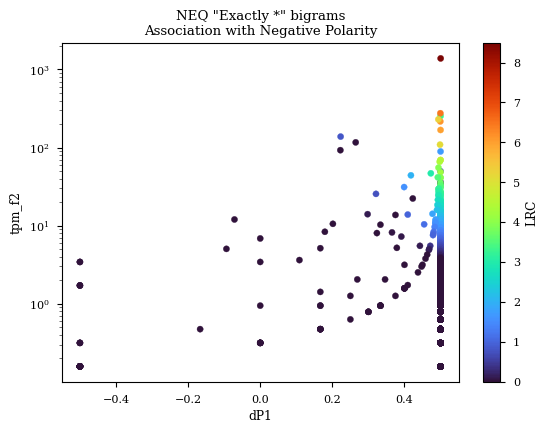

In [730]:
for s, _df in all_exactly_bigrams.loc[all_exactly_bigrams.polarity == 'neg' , :].groupby('pos_sample'):
    _df.plot(kind='scatter', y='tpm_f2',logy=True, x='dP1', c='LRC', colormap='turbo',
             title=f'{s} "Exactly *" bigrams\nAssociation with Negative Polarity')

In [731]:
plot_quantiles(all_exactly_bigrams, sqrt=False, #base=r'f',
               columns=['f','f2', 'adj_total'], 
               log_y=True, per_mill=False, include_mean=False, plot_kind='line')

In [732]:
plot_quantiles(all_exactly_bigrams, sqrt=False, #base=r'f',
               columns=[f'tpm_{f}' for f in ['f','f2', 'adj_total']], 
               log_y=True, per_mill=True, include_mean=False, plot_kind='line')

In [733]:
plot_quantiles(all_exactly_bigrams, sqrt=False, #base=r'f',
               columns=['f','f2', 'adj_total'], 
               log_y=True, per_mill=False, include_mean=False, plot_kind='line')

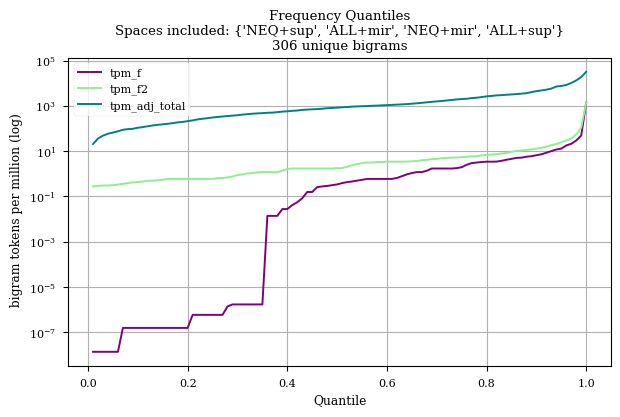

In [734]:
plot_quantiles(exactly_bigrams, columns=['tpm_f','tpm_f2', 'tpm_adj_total'], log_y=True, per_mill=True, plot_kind='line')

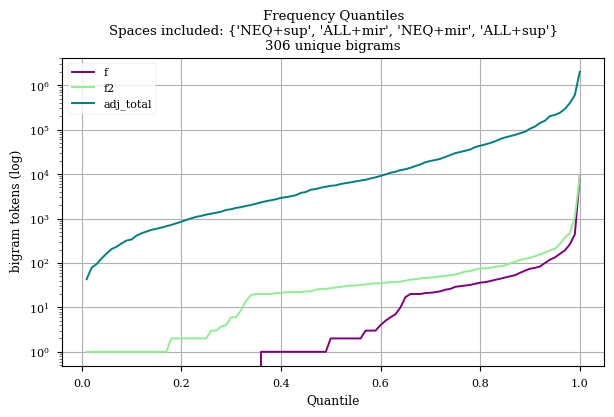

In [735]:
plot_quantiles(exactly_bigrams, columns=['f','f2', 'adj_total'], log_y=True, per_mill=False, plot_kind='line')

In [736]:
df_for_sty = (skewed_bigrams
    .reset_index().drop_duplicates(['polarity','adj'])
    .set_index(['adj','polarity', ])[['dP1m', 'LRCm', 'G2m', 'P1m', 'tpm_f_sqrt_m', 'tpm_f2_sqrt_m']].round(2)
    .sort_values(['dP1m', 'LRCm'], ascending=False)).unstack('polarity')

sty = set_my_style(
    df_for_sty, precision=2
).background_gradient(
    cmap='seismic', subset=['dP1m', 'LRCm', 'G2m'], axis=0
).background_gradient(
    cmap='purple_rain', subset=['P1m'], axis=None
).background_gradient(
    cmap='purple_rain', subset=['tpm_f_sqrt_m', 'tpm_f2_sqrt_m'], axis=None
).highlight_max(color='gold', props='color: black; background-color:gold; font-weight: bold;')
# sty.to_html(SANPI_HOME.joinpath(
#     f'info/writing_links/imports/tables/ExactlyBigrams/skewed_exactly-bigrams_means.{timestamp_today()}.html'))
# print(f'Saved as\n  tables/ExactlyBigrams/skewed_exactly-bigrams_means.{timestamp_today()}.html')
save_html(sty, f'skewed_exactly-bigrams_means.{timestamp_today()}.html','ExactlyBigrams_skewed' )

html table saved as
  "imports/tables/ExactlyBigrams_skewed/skewed_exactly-bigrams_means.2025-01-07.html.2025-01-07.html"


In [737]:
style_crosstab(skewed_bigrams.reset_index(), ['adj'], ['pos_sample', 'polarity', 'dataset'], value_col='dP1',
               prefilter_label='ExactlyBigrams_skewed', aggfunc='mean', cmap='anastasia', cmap2=None, axis=None, group=True, precision=3)

formatted table saved as html: imports/tables/ExactlyBigrams_skewed/adj_dP1-mean_pos_sample-polarity-dataset_color-table_grouped.2025-01-07_02.html


In [738]:
style_crosstab(skewed_bigrams.reset_index(), ['adj'], ['dataset', 'pos_sample', 'polarity'], value_col='LRC',
               prefilter_label='ExactlyBigrams_skewed', aggfunc='mean', cmap='anastasia', axis=None, group=True, precision=2)

formatted table saved as html: imports/tables/ExactlyBigrams_skewed/adj_LRC-mean_dataset-pos_sample-polarity_color-table_grouped.2025-01-07_02.html


In [739]:
mir_exactly_bigrams = exactly_bigrams.loc[(
    exactly_bigrams.dataset == 'mirror'), :]
style_crosstab(mir_exactly_bigrams.loc[mir_exactly_bigrams['LRC!=0'], :],
               ['adj'], ['pos_sample', 'polarity'], value_col='LRC', sort_col_vals=('ALL', 'neg'),
               prefilter_label='Mirror_ExactlyBigrams', aggfunc='mean', cmap='anastasia', axis=None, group=True)

formatted table saved as html: imports/tables/Mirror_ExactlyBigrams/adj_LRC-mean_pos_sample-polarity_color-table_grouped.2025-01-07_02.html


In [740]:
# for skewed_b in skewed_bigrams.l2.unique():
#     _ex_bigram = exactly_bigrams.loc[exactly_bigrams.l2 == skewed_b, :]
#     style_crosstab(_ex_bigram, ['dataset',], ['l2', 'pos_sample', 'polarity'],
#                    'LRC',
#                    axis=None, group=False,
#                    prefilter_label=f'skewed-{skewed_b}')

In [741]:
sup_exactly_bigrams = exactly_bigrams.loc[(
    exactly_bigrams.dataset == 'super'), :]
sup_30_most_freq = sup_exactly_bigrams.groupby(
    'adj').tpm_f2.mean().nlargest(30).index.to_list()
# style_crosstab(sup_exactly_bigrams.loc[sup_exactly_bigrams.adj.isin(sup_30_most_freq), :],
#                ['adj'], ['pos_sample', 'polarity'], value_col='dP1', 
#                cmap='cividis',
#                prefilter_label='Super_ExactlyBigrams_30mostFrequent',
#                aggfunc='mean', axis=None, group=False)

In [742]:
# style_crosstab(exactly_bigrams.loc[exactly_bigrams.adj.isin(sup_30_most_freq), :],
#                ['adj'], ['dataset', 'polarity', 'pos_sample'], value_col='LRC',
#                prefilter_label='Super_ExactlyBigrams_30mostFrequent',
#                sort_col_vals=('super', 'neg', 'ALL'),
#                aggfunc='mean', cmap='anastasia', axis=None, group=False)

In [743]:
style_crosstab(skewed_bigrams.reset_index(), ['adj'], ['dataset', 'polarity'], value_col='tpm_unexp_f',
               prefilter_label='ExactlyBigrams', aggfunc='mean', cmap='seismic', cmap2='RdBu_r', axis=None, group=True, precision=2)

formatted table saved as html: imports/tables/ExactlyBigrams/adj_tpm_unexp_f-mean_dataset-polarity_color-table_grouped.2025-01-07_02.html


In [744]:
# exactly_bigrams.assign(deqP1=exactly_bigrams.dP1 * exactly_bigrams.reset_index().pos_sample.map({'ALL':1, 'NEQ': 2}) )

# exactly_bigrams = exactly_bigrams.assign(
#     deqP1 = (exactly_bigrams.reset_index().dP1 *
#              exactly_bigrams.reset_index().pos_sample.map({'ALL':1, 'NEQ': 2})).to_list())

## Context-Blind Adjective Association with *Exactly*

In [6]:
blind_exactly_csv = (TOP_AM_DIR / 'exactly' /
                     f'combined_exactly~ADJ_AM-blind.csv')
if blind_exactly_csv.is_file():
    blind = pd.read_csv(blind_exactly_csv,
                        index_col='space_key').convert_dtypes()
    print(
        f'previously compiled loaded from "{blind_exactly_csv.relative_to(SANPI_HOME)}"')
else:
    blind = load_all_relevant_ams(
        {'exactly', }, unit='adv_adj', label='exactly-blind', f_min=1, reprocess=True)
    blind = update_amdf(blind, polar=False).convert_dtypes()
    blind = add_space_info(blind)
    blind['deltaP_mean_m'] = blind.l2.map(
    force_am_mean(blind, 'deltaP_mean', polar=False, grouper='l2'))
    blind = eval_sig(blind)
    blind = designate_bins(blind, 'tpm_f1')
    blind = designate_bins(blind, 'tpm_f2')
    blind = designate_bins(blind, 'tpm_f')
    blind = designate_bins(blind, 'tpm_f_m')
    blind.to_csv(blind_exactly_csv)

previously compiled loaded from "results/top_AM/exactly/combined_exactly~ADJ_AM-blind.csv"


In [7]:
exactly_total = blind.f1.max()
any_f_top_blind_allsup_m = (
    blind
    .filter(like='ALL+sup', axis=0)
    .nlargest(10, ['LRCm', 'deltaP_mean_m'])
    .filter(['l2', 
             'f', #'tpm_f', 
            #  'f1',
             'f2', #'tpm_f2',
             'LRC', 'deltaP_mean', 
             'dP1',  'P1','dP2', 'P2', 
             ])
    .rename(columns={'deltaP_mean': '∆P avg', 
                     'dP1':'∆P(x|ADJ)',
                     'P1':'P(x|ADJ)',
                     'dP2':'∆P(ADJ|x)',
                     'P2':'P(ADJ|x)',
                     'l2':'ADJ'})
    .set_index('ADJ')
    )
    

set_my_style(any_f_top_blind_allsup_m,
             index_font='CMU classical serif', index_size=10, data_size=8.25, 
             caption= ('Strongest Context-Blind Associations<br/>'
                       f'across all {exactly_total:,} <i>exactly</i> bigrams<br/>'
                       '(no minimum frequency)'
                       ), 
             precision=3
             ).background_gradient(cmap='RdPu')

In [8]:
blind.l2.describe()

count          8379
unique         3995
top       satisfied
freq              4
Name: l2, dtype: object

In [9]:
blind.filter(like='+mir', axis=0).l2.describe()

count             629
unique            321
top       downtrodden
freq                2
Name: l2, dtype: object

In [10]:
all_super_blind = blind.filter(like='ALL+sup', axis=0)
all_super_blind.filter(['f','f2','exp_f']).describe()

f           f2    exp_f
count 3,995.00     3,995.00 3,995.00
mean     14.04    15,960.10    12.44
std     181.29    74,993.22    58.47
min       1.00         1.00     0.00
25%       1.00        92.50     0.07
50%       1.00     1,250.00     0.97
75%       4.00     7,022.50     5.48
max   8,840.00 2,001,942.00 1,560.93

In [11]:
quant_floor = 0.3
f_floor = 50
print_iter([
    f'f >= {f_floor}',
    # f'[ >= {quant_floor*100:.0f}th Percential ]',
    # f'f2 >= {f_floor}'
],
    header=f'Context-Blind Frequency Restrictions:')
super_blind_common = all_super_blind.loc[
    (#> restrict joint frequency: # tokens of "exactly ADJ" for each ADJ
        (all_super_blind.f >= f_floor)
    #> restrict adjective marginal frequency (all tokens with or without "exactly")
    # &
    # (all_super_blind.f2 >= f_floor)
    # (all_super_blind.f2 >= all_super_blind.f2.quantile(quant_floor))
    ), :]

# super_blind_common
# super_blind_common.filter(['f', 'f2', 'exp_f']).describe()


Context-Blind Frequency Restrictions:
▸ f >= 50



In [12]:
super_blind_common.loc[
    super_blind_common.dP2.round(2) > 0.01
].filter(
    regex=r'[Pf]\d?'
).iloc[:, :6].style.text_gradient('violet_seafoam_pink_r', high=0.1, low=0.2)

In [18]:
k = K
print(f'Seeking top {K} adjectives...')


NameError: name 'K' is not defined

In [ ]:
top_k_super_blind = (
    pd.concat(
        (super_blind_common.nlargest(
            k-5, ['LRC', 'f']),
        super_blind_common.nlargest(
            k, ['deltaP_max', 'LRC', ]),
        # super_blind_common.nlargest(
        #     k, ['dP1', 'LRC', ]),
        # super_blind_common.loc[blind.l2.isin(mirror_adj)].nlargest(
        #     k+5, ['LRC', 'dP2'])
         )
    )
    # .filter(COLUMN_LIST
    #         + ['dP2', 'dP2m', 'P2', 'P2m', 'G2', 'G2m',
    #            'tpm_f_m', 'f_m', 'f2_m', 'tpm_unexp_f', 'tpm_f', 'tpm_f2', 'tpm_f1',
    #            'deltaP_mean', 'unexp_r', 'tpm_unexp_f_sqrt', 'f1_sqrt',
    #            'tpm_f_sqrt', 'tpm_f2_sqrt', 'tpm_f1_sqrt'])
    .drop_duplicates()
    # .nlargest(k, ['LRC', 'unexp_r'])
    .filter(['l2',
             # 'dataset', 'pos_sample', 'space', 'tpm_unexp_f',
             'LRC', 'deltaP_max', 'deltaP_mean',
             'dP1',  # 'P1',
             'dP2',  # 'P2',
             'G2',
             'unexp_r',
             'f',  # 'tpm_f',
             'f2',  # 'tpm_f2'
             ])
)

def show_top_blind(top_k_blind, 
                   sort_by='LRC', k=None, 
                   quant_floor=quant_floor):
    
    k = k or len(top_k_blind)
    top_k_blind = (
        top_k_blind
        .nlargest(k, sort_by)
        .reset_index(drop=True).reset_index()
        .rename(
            columns={'index': 'rank',
                     'l2': 'exactly...',
                     'deltaP_mean': '∆P avg',
                     'deltaP_max': '∆P max',
                     'dP1': '∆P(x|ADJ)',
                     'P1': 'P(x|ADJ)',
                     'dP2': '∆P(ADJ|x)',
                     'P2': 'P(ADJ|x)'}
        ))
    format_top_blind = top_k_blind.assign(
        rank=top_k_blind['rank']+1
    ).set_index(['rank', 'exactly...'])
    sty = (
        set_my_style(
            format_top_blind,
            caption=('Adjectives with strongest context-blind associations with <i>exactly</i><br/>'
                     '<i>based on <code>ALL+</code> superset only; ranked by LRC</i><br/>'
                     '<code>{f2,f} '
                     f'≥ {f_floor}</code>'
                    #//  f' ({quant_floor*100:.0f}th percential)'
                     ),
            index_font='CMU classical serif', 
            precision=3, data_size=8, index_size=9.5, col_size=9.5)
        .background_gradient(cmap='PuRd', axis=0, low=0.055)
        #    .format(subset=['G2', 'tpm_f', 'tpm_f2'], precision=1, thousands=',')
        #    .format(subset=['LRC'], precision=2)
    )
    return save_html(sty, f'top{k}_ALLsuper', 'exactly_blind')

display(show_top_blind(top_k_super_blind.round(3), k=K,  sort_by=['LRC', 'dP2']))
top_k_super_blind = top_k_super_blind.nlargest(k, ['LRC', 'deltaP_mean'])
top_k_super_blind.reset_index(drop=True).reset_index().set_index(['index', 'l2'])

### Specific Examples for blind cohesion

In [14]:
show_example_l2(blind, example_l2='sure', 
                 columns=['LRC', 'P1', 'dP1', 'P2', 'dP2', 'tpm_f', 'tpm_unexp_f', 'unexp_r'], 
                transpose=True, cmap='PuRd',
                index_order = ['l1','l2', 'dataset', 'pos_sample', 'f2', 'direction', 'f'])


html table saved as
  "imports/tables/env~l2_examples/sure/exactly~sure_example-table.2025-01-07.html"


In [15]:
show_example_l2(blind, example_l2=blind[blind.tpm_f_m_quantile>0.7].sample(1).l2.squeeze(), 
                 columns=['LRC', 'tpm_f', 'tpm_unexp_f', 'unexp_r', 'P1', 'dP1', 'P2', 'dP2'], 
                transpose=True, 
                cmap='ocean_r', precision=2,
                index_order = ['l1','l2', 'dataset','direction',   'pos_sample','f2', 'f'])


html table saved as
  "imports/tables/env~l2_examples/remarkable/exactly~remarkable_example-table.2025-01-07.html"


In [16]:
format_negatives(show_example_l2(blind, example_l2=blind.loc[(blind.tpm_f_m>1), :].sample(1).l2.squeeze(),
                columns=['LRC', 'tpm_f', 'tpm_unexp_f', 'unexp_r', 'P1', 'dP1', 'P2', 'dP2'], 
                transpose=True, 
                cmap='ocean_r', precision=2,
                index_order = ['l1','l2', 'dataset','direction',   'pos_sample','f2', 'f']
                ))

html table saved as
  "imports/tables/env~l2_examples/unknown/exactly~unknown_example-table.2025-01-07.html"


In [17]:
blind_for_join = (blind
                  .loc[blind.l2.isin(pd.concat([top_k_super_blind.l2, polar_skewed_bigram_adj])), :]
                  .filter(['l2', 'dataset', 'pos_sample', 'LRC', 'deltaP_mean', 'deltaP_max','dP1', 'dP2', 'unexp_r'])
                  .rename(columns={'l2': 'adj'}).set_index(['adj', 'dataset', 'pos_sample']))
# blind_for_join.head()
for_sty = (blind_for_join.filter(['LRC', 'dP1', 'dP2'])
           .reset_index())
for_sty = (for_sty.loc[for_sty.adj.isin(top_k_super_blind.l2)]
           .rename(
               columns={'index': 'rank', 
                        'adj': 'exactly...',
                        'deltaP_mean': '∆P avg',
                        'dP1': '∆P(x|ADJ)',
                        'P1': 'P(x|ADJ)',
                        'dP2': '∆P(ADJ|x)',
                        'P2': 'P(ADJ|x)'})
           .set_index(
               ['dataset', 'pos_sample', 'exactly...',])
           .unstack(
               ['dataset', 'pos_sample',])
           .sort_index(axis=1, level=[0, 'dataset'])
           .sort_values(('LRC', 'super', 'ALL'), ascending=False))

for_sty = rank_rows(for_sty)


sty = set_my_style(for_sty
                   .style.set_caption(f'Top {k} Adjectives with strongest context-blind associations with "exactly"<br/>(based on <code>ALL+</code> superset only)')
                   .background_gradient(subset=for_sty.filter(like='LRC').columns, cmap='purple_rain', low=0.05)
                   .background_gradient(subset=for_sty.filter(like='P(ADJ').columns, cmap='BuPu', axis=None, low=0.02, high=0.01)
                   .background_gradient(subset=for_sty.filter(like='P(x').columns, cmap='RdPu', axis=None, low=0.02, high=0.01)
                   .highlight_between(left=-0.009, right=0.009, props='opacity:80%'),
                   index_font='CMU classical serif', index_size=9, data_size=8.25, precision=2, col_size=9.5)
save_html(sty,    subdir='exactly_blind',
          stem=f'top{k}_blind4')

sty

NameError: name 'polar_skewed_bigram_adj' is not defined

#### Entire Set of Significant Blind Associations by Comparison Space

In [55]:
# blind = designate_bins(blind, 'P1')
tag = 'ALL'
dataset = 'mirror'
_table_data = blind.set_index(['dataset', 'pos_sample', 'direction', 'l2']).sort_index().xs((dataset, tag, 'attract')).filter(
        ['LRC', 'G2', 'dP1', 'dP2', #'P1', 'P2',
         'f', 'tpm_f', 'tpm_f2', 'l2', 'pos_sample']
        ).sort_values('LRC', ascending=False)
save_html(set_my_style(_table_data)    
          .background_gradient()
          .background_gradient('YlGnBu', subset=['dP1', 'dP2'], axis=0)
          .background_gradient('YlGnBu',subset=['LRC','G2'], axis=0)
          .set_caption(f'All Significant Context-Blind Attractions with <i>exactly</i><br/>in <code>{tag}+</code> {dataset} data'.title()+f'<br/>{len(_table_data):,} unique in total'),
subdir='exactly_blind', stem=f'attract_{tag}+{dataset[:3]}_adjectives')


html table saved as
  "imports/tables/exactly_blind/attract_ALL+mir_adjectives.2025-01-07.html"


In [56]:
tag = 'NEQ'
dataset = 'mirror'
_table_data = blind.set_index(['dataset', 'pos_sample', 'direction', 'l2']).sort_index().xs((dataset, tag, 'attract')).filter(
        ['LRC', 'G2', 'dP1', 'dP2', #'P1', 'P2',
         'f', 'tpm_f', 'tpm_f2', 'l2', 'pos_sample']
        ).sort_values('LRC', ascending=False)
save_html(set_my_style(_table_data)    
          .background_gradient()
          .background_gradient('YlGnBu', subset=['dP1', 'dP2'], axis=0)
          .background_gradient('YlGnBu',subset=['LRC','G2'], axis=0)
          .set_caption(f'All Significant Context-Blind Attractions with <i>exactly</i><br/>in <code>{tag}+</code> {dataset} data'.title()+f'<br/>{len(_table_data):,} unique in total'),
subdir='exactly_blind', stem=f'attract_{tag}+{dataset[:3]}_adjectives')


html table saved as
  "imports/tables/exactly_blind/attract_NEQ+mir_adjectives.2025-01-07.html"


In [57]:

tag = 'NEQ'
dataset = 'super'
_table_data = blind.set_index(['dataset', 'pos_sample', 'direction', 'l2']).sort_index().xs((dataset, tag, 'attract')).filter(
        ['LRC', 'G2', 'dP1', 'dP2', #'P1', 'P2',
         'f', 'tpm_f', 'tpm_f2', 'l2', 'pos_sample']
        ).sort_values('LRC', ascending=False)
save_html(set_my_style(_table_data)    
          .background_gradient()
          .background_gradient('YlGnBu', subset=['dP1', 'dP2'], axis=0)
          .background_gradient('YlGnBu',subset=['LRC','G2'], axis=0)
          .set_caption(f'All Significant Context-Blind Attractions with <i>exactly</i><br/>in <code>{tag}+</code> {dataset} data'.title()+f'<br/>{len(_table_data):,} unique in total'),
subdir='exactly_blind', stem=f'attract_{tag}+{dataset[:3]}_adjectives')

html table saved as
  "imports/tables/exactly_blind/attract_NEQ+sup_adjectives.2025-01-07.html"


In [58]:
tag = 'ALL'
dataset = 'super'
_table_data = blind.set_index(['dataset', 'pos_sample', 'direction', 'l2']).sort_index().xs((dataset, tag, 'attract')).filter(
        ['LRC', 'G2', 'dP1', 'dP2', #'P1', 'P2',
         'f', 'tpm_f', 'tpm_f2', 'l2', 'pos_sample']
        ).sort_values('LRC', ascending=False)
save_html(set_my_style(_table_data)    
          .background_gradient()
          .background_gradient('YlGnBu', subset=['dP1', 'dP2'], axis=0)
          .background_gradient('YlGnBu',subset=['LRC','G2'], axis=0)
          .set_caption(f'All Significant Context-Blind Attractions with <i>exactly</i><br/>in <code>{tag}+</code> {dataset} data'.title()+f'<br/>{len(_table_data):,} unique in total'),
subdir='exactly_blind', stem=f'attract_{tag}+{dataset[:3]}_adjectives')

html table saved as
  "imports/tables/exactly_blind/attract_ALL+sup_adjectives.2025-01-07.html"


## Blind vs. Polar Associations

In [59]:
blind_top_adj = set(top_k_super_blind.l2)
polar_top_adj = set(polar_skewed_bigram_adj)
polar_skew_top_blind = all_exactly_bigrams.loc[all_exactly_bigrams.adj.isin(
    blind_top_adj), :]
polar_skew_top = pd.concat([polar_skew_top_blind.assign(top='blind'), 
                            skewed_bigrams.assign(top='polar')])
in_both_top = polar_skew_top.index.to_series().duplicated(keep=False)
polar_skew_top.loc[in_both_top, 'top'] = 'both'
polar_skew_top.loc[polar_skew_top.top=='both'].l2.nunique()

8

In [60]:
top_adj_counts = polar_skew_top.reset_index()[['adj','top']].drop_duplicates().value_counts('top').to_frame().sort_index()
top_adj_counts.loc['SUM', 'count'] = top_adj_counts['count'].sum()
set_my_style(top_adj_counts, precision=0)

In [61]:
polar_for_join = (
    polar_skew_top.loc[polar_skew_top.polarity == 'neg', :]
    .set_index(['adj', 'dataset', 'pos_sample'])
    .filter(
        ['l2', 'dataset', 'pos_sample', 'LRC', 'deltaP_mean', 'deltaP_max', 'dP1', 'dP2', 'unexp_r',
         'adj_total', 'tpm_adj_total', 'f', 'tpm_f', 'f2', 'tpm_f2', ])
)
# vs = polar_for_join.join(
#     blind_for_join, rsuffix='_blind', lsuffix='_neg'
# )
vs = pd.concat([polar_for_join.assign(eval='(-) Bigram'),
                blind_for_join.assign(eval='Blind')]).reset_index().set_index(['adj', 'dataset', 'pos_sample', 'eval']).sort_index()
vs = vs.filter(regex=r'LRC|unexp_r|deltaP_max').sort_index(axis=1)
# vs

In [62]:


def add_top_label(df, blind_top = blind_top_adj, polar_top= polar_top_adj):
    indexers = list(df.index.names)
    columns = df.columns.to_list()
    _df = df.copy()
    if any(indexers): 
        _df = _df.reset_index()
    
    adj = _df.filter(['adj','l2']).iloc[:, 0]
    in_top_blind = adj.isin(blind_top)
    in_top_polar = adj.isin(polar_top)
    
    _df.loc[in_top_blind, 'top'] = 'blind'
    _df.loc[in_top_polar, 'top'] = 'polar'
    _df.loc[in_top_blind & in_top_polar, 'top'] = 'both'
    _df = _df.filter(['top']+columns + indexers)
    return _df.set_index(['top'] + indexers) if any(indexers) else _df


In [63]:

# polar_skew_top = add_top_label(polar_skew_top)

style_crosstab(polar_skew_top.reset_index(),  ['top','adj'], ['adv','polarity',  'dataset', 'pos_sample'],
               sort=False,
            #    sort_col_vals=('exactly', 'neg', 'super', 'ALL'),
               value_col='LRC',
               axis=None, 
            #    group_col='pos_sample', cmap2=None,
               group=False, 
               precision=2,
               aggfunc='mean', cmap='purple_teal',
               prefilter_label='polar-prone_top-blind_exactly'
               )

formatted table saved as html: imports/tables/polar-prone_top-blind_exactly/top-adj_LRC-mean_adv-polarity-dataset-pos_sample_color-table.2025-01-07_17.html


In [ ]:
_vs = add_top_label(vs).reset_index().drop_duplicates(
).set_index(['top'] + vs.index.names)
max_lrc = _vs.LRC.max()
min_lrc = _vs.LRC.min()
lrc_dpmax_vs = _vs.filter(['LRC', 'deltaP_max'])
set_my_style(lrc_dpmax_vs.head(12))

In [152]:
display(style_crosstab(lrc_dpmax_vs.reset_index(), ['top', 'adj'], ['eval','dataset'],
               value_col= 'LRC', aggfunc='mean', sort=False, 
               group=True, axis=None, 
               group_col='eval',
               cmap2='RdBu_r', cmap='PuOr_r',
               vmin=(-1*max_lrc), vmax=max_lrc
               ))
display(style_crosstab(lrc_dpmax_vs.reset_index(), ['top', 'adj'], ['eval','dataset',],
               value_col= 'deltaP_max', aggfunc='mean', sort=False, 
               group=True, axis=None, 
               group_col='eval',
               cmap='PRGn', cmap2='cerulean_royalty_r',
               vmin=-1, vmax=1, precision=2
               ))

formatted table saved as html: imports/tables/top-adj_LRC-mean_eval-dataset_color-table_grouped.2025-01-07_18.html


formatted table saved as html: imports/tables/top-adj_deltaP_max-mean_eval-dataset_color-table_grouped.2025-01-07_18.html


In [154]:
multicol_vs = lrc_dpmax_vs.unstack(['eval', 'dataset',  'pos_sample']
                  ).sort_index(axis=1).sort_index()
for top_set in set(multicol_vs.index.get_level_values('top')).union({'mixed'}):
    _for_sty = multicol_vs.copy()
    if top_set != 'mixed':
        _for_sty = _for_sty.loc[(_for_sty.reset_index(
            level='top').top == top_set).to_list(), :]

    print(f'\n**{top_set}**')
    sty = format_zeros(
        format_negatives(
            set_my_style(_for_sty, index_font='CMU classical serif',
                         caption=f'<i>Exactly *</i> Bigram Associations for Top ADJ<br/>Context-Blind Cohesion and Negative Polarity Sensitivity<br> showing top ADJ for: <u>{top_set}</u>',
                         precision=2, index_size=8.5, data_size=8, col_size=9)
            .background_gradient(cmap='RdPu', subset=multicol_vs.filter(like='LRC').columns, axis=None, vmin=min_lrc, vmax=max_lrc)
            .background_gradient(cmap='cerulean_royalty', subset=multicol_vs.filter(like='delta').columns, axis=None, vmin=-1, vmax=1)
            #    .background_gradient(cmap='Reds', subset=multicol_vs.filter(like='delta').columns, axis=None)
            # .background_gradient(cmap='coolwarm', subset=multicol_vs.filter(like='unexp').columns, axis=None, vmin=-1, vmax=1)
        ))
    display(save_html(sty, subdir='exactly_top-ADJ',
            stem=f'top-{top_set}_NegVsBlind'))


**mixed**
html table saved as
  "imports/tables/exactly_top-ADJ/top-mixed_NegVsBlind.2025-01-07.html"



**blind**
html table saved as
  "imports/tables/exactly_top-ADJ/top-blind_NegVsBlind.2025-01-07.html"



**polar**
html table saved as
  "imports/tables/exactly_top-ADJ/top-polar_NegVsBlind.2025-01-07.html"



**both**
html table saved as
  "imports/tables/exactly_top-ADJ/top-both_NegVsBlind.2025-01-07.html"


In [ ]:
for top_set in set(multicol_vs.index.get_level_values('top')).union({'mixed'}):
    _for_sty = multicol_vs.copy()
    if top_set != 'mixed':
        _for_sty = _for_sty.loc[(_for_sty.reset_index(
            level='top').top == top_set).to_list(), :]

    print(f'\n**{top_set}**')
    sty = format_zeros(
        format_negatives(
            set_my_style(_for_sty, index_font='CMU classical serif',
                         caption=f'<i>Exactly *</i> Bigram Associations for Top ADJ<br/>Context-Blind Cohesion and Negative Polarity Sensitivity<br> showing top ADJ for: <u>{top_set}</u>',
                         precision=3, index_size=8.5, data_size=8, col_size=9)
            .background_gradient(cmap='RdPu', subset=multicol_vs.filter(like='LRC').columns, axis=None, vmin=min_lrc, vmax=max_lrc)
            .background_gradient(cmap='cerulean_royalty', subset=multicol_vs.filter(like='delta').columns, axis=None, vmin=-1, vmax=1)
            #    .background_gradient(cmap='Reds', subset=multicol_vs.filter(like='delta').columns, axis=None)
            # .background_gradient(cmap='coolwarm', subset=multicol_vs.filter(like='unexp').columns, axis=None, vmin=-1, vmax=1)
        ))
    display(save_html(sty, subdir='exactly_top-ADJ',
            stem=f'top-{top_set}_NegVsBlind'))

The above table of `LRC` values indicates that the 25 adjectives most likely to appear with _exactly_ overall 
    do not necessarily yield a bigram (`exactly_[ADJ]`) which exhibits a negative polarity preference. 
Seven of the top twenty-five 
    bigrams—"_exactly divisible_", "_exactly halfway_",
    "_exactly opposite_", "_exactly same_",
    "_exactly perpendicular_", "_exactly solvable_", and "_exactly zero_"—show 
no significant environment association 
    in any of the 4 comparison spaces (either LRC value of 0 or unattested in the selected data).
 
Many others are insignificant 
    (e.g. _exacty_ {_cheap_, _ideal_, _conducive_, _thrilled_, _stellar_, _true_, _correct_, _equivalent_, _equal_}) 
or unattested 
    (e.g. _exactly_ {_forthcoming_, _appetizing_, _flush_, _analogous_}) 
in the mirror evaluation, 
    despite reaching sigificance in at least the nonsampled (`ALL`) superset comparison, 
Interstingly, _exactly parallel_ is insignificant in the full mirror subset, 
    but unattested in the negative equivalent sample,
    and the same is true for _exactly halfway_ in the superset. 
This fact is telling because the NEQ sample is identical for all negative polarity tokens: 
    _exactly parallel_ has zero negative environment appearances in the mirror subset, 
    and _exactly halfway_ has zero negative environemnt appearances in the superset 
    (and no appearances at all in the mirror subset).

---

**ChatGPT rephrase**  
> The table of `LRC` values above demonstrates that the 25 adjectives most commonly occurring with the word _exactly_ do not necessarily form bigrams (i.e., `exactly_[ADJ]`) that exhibit a tendency toward negative polarity. Seven of the top twenty-five bigrams—_exactly divisible_, _exactly halfway_, _exactly opposite_, _exactly same_, _exactly perpendicular_, _exactly solvable_, and _exactly zero_—show no significant association with any of the four comparison spaces. In these instances, the LRC value is either zero, or the bigram is unattested in the selected data. Furthermore, several other bigrams are either insignificant (e.g., combinations with _cheap_, _ideal_, _conducive_, _thrilled_, _stellar_, _true_, _correct_, _equivalent_, and _equal_) or unattested (e.g., combinations with _forthcoming_, _appetizing_, _flush_, and _analogous_) in the mirror evaluation, despite showing significance in at least one of the comparisons within the larger nonsampled (`ALL`) superset.
> 
> Notably, the bigram _exactly parallel_ is insignificant in the full mirror subset, yet it is unattested in the negative equivalent sample. A similar pattern is observed for _exactly halfway_ in the superset. This observation holds significance, as the NEQ sample is consistent across all negative polarity tokens: _exactly parallel_ has zero negative environment appearances in the mirror subset, and _exactly halfway_ has zero negative environment appearances in the superset, with no occurrences at all in the mirror subset. These findings suggest a nuanced relationship between the adjective _exactly_ and its surrounding contexts, highlighting the need for further exploration of the factors influencing polarity in such bigrams.

In [767]:
# style_crosstab(polar_skew_top_blind, ['adj'],  ['adv', 'dataset', 'polarity', 'pos_sample'],
#                sort=False,
#                sort_col_vals=('exactly', 'super', 'neg', 'ALL'),
#                value_col='P1', axis=None, group=False,  precision=2,
#                aggfunc='mean', 
#                cmap='BuPu', 
#                prefilter_label='polar-prone_top-blind_exactly'
#                )

In [155]:
style_crosstab(polar_skew_top, ['top','adj'],  ['adv','polarity', 'dataset', 'pos_sample'],
               sort=False,
               sort_col_vals=('exactly','super', 'neg', 'ALL'),
               value_col='dP1', axis=None, 
            #    group=False,
               group_col='pos_sample', cmap2=None,
               aggfunc='mean',
               cmap='PRGn', 
               prefilter_label='polar-prone_top-blind_exactly'
               )

formatted table saved as html: imports/tables/polar-prone_top-blind_exactly/top-adj_dP1-mean_adv-polarity-dataset-pos_sample_color-table_grouped.2025-01-07_18.html


In [769]:
style_crosstab(polar_skew_top, ['top', 'adj'], ['adv', 'dataset', 'pos_sample', 'polarity'],
               sort_col_vals=('exactly',  'super', 'ALL', 'neg'),
               value_col='unexp_r', 
               axis=None, sort=False,
            #    group=False, 
               group_col='pos_sample', cmap2=None,
               precision=3,
               aggfunc='mean', cmap='RdBu_r', 
               prefilter_label='polar-prone_top-blind_exactly'
               )

formatted table saved as html: imports/tables/polar-prone_top-blind_exactly/top-adj_unexp_r-mean_adv-dataset-pos_sample-polarity_color-table_grouped.2025-01-07_02.html


In [770]:
_juxta = set(polar_skew_top.adj.astype('string').drop_duplicates().to_list())

1. sure
1. clear
1. revolutionary
1. cheap
1. ideal
1. stellar
1. conducive
1. thrilled
1. novel
1. new
1. true
1. zero
1. alike
1. right
1. opposite
1. parallel
1. correct
1. same
1. equivalent
1. equal
1. forthcoming
1. reassuring
1. comparable
1. analogous
1. perpendicular
1. easy
1. surprising
1. subtle
1. shy
1. great
1. famous
1. unexpected
1. straightforward
1. happy
1. friendly
1. difficult
1. impressive
1. shocking
1. uncommon
1. pleasant
1. welcome
1. fair

## $E\sim\texttt{adj}$ associations for top adjectives: blind and polar preference

In [771]:
#
# ^ sanity checks
# print(len(polar_top_adj), ':', polar_top_adj, end='\n\n---\n\n')
# print(len(polar_top_adj.difference(_juxta)), ':', polar_top_adj.difference(_juxta), end='\n\n---\n\n')
# print(len(blind_top_adj), ':', blind_top_adj, end='\n\n---\n\n')
# print(len(blind_top_adj.difference(_juxta)), ':', blind_top_adj.difference(_juxta), end='\n\n---\n\n')
# print(len(polar_top_adj.intersection(blind_top_adj)), ':', polar_top_adj.intersection(blind_top_adj), end='\n\n---\n\n')
# print(len(polar_top_adj.union(blind_top_adj)), ':', polar_top_adj.union(blind_top_adj), end='\n\n---\n\n')
# print(len(_juxta), ':', _juxta, end='\n\n---\n\n')
# print(len(polar_top_adj.difference(blind_top_adj)), ':', polar_top_adj.difference(blind_top_adj), end='\n\n---\n\n')
# print(len(blind_top_adj.difference(polar_top_adj)), ':', blind_top_adj.difference(polar_top_adj), end='\n\n---\n\n')

In [801]:
FORCE_RELOAD = False
top_adj_independent_csv = TOP_AM_DIR.joinpath(
    'exactly/combined_env~ADJ_top-exactly.csv')
if FORCE_RELOAD or (not top_adj_independent_csv.is_file()):
    # polar_top = set(polar_skewed_bigram_adj)
    exactly_adj_amdf = update_amdf(
        load_all_relevant_ams(polar_top_adj.union(blind_top_adj),
                              unit='adj',
                              reprocess=FORCE_RELOAD,
                              label='exactly-prone'))

    in_top_blind = exactly_adj_amdf.l2.isin(blind_top_adj)
    in_top_polar = exactly_adj_amdf.l2.isin(polar_top_adj)
    exactly_adj_amdf.loc[in_top_blind, 'top'] = 'blind'
    exactly_adj_amdf.loc[in_top_polar, 'top'] = 'polar'
    exactly_adj_amdf.loc[in_top_blind & in_top_polar, 'top'] = 'both'
    exactly_adj_amdf['top_blind'] = in_top_blind
    exactly_adj_amdf['top_polar'] = in_top_polar
    exactly_adj_amdf.to_csv(top_adj_independent_csv)
    print('Combined env~adj AMs for top "exactly" adjectives (blind & polar) saved as:\n'
          f'  + "{top_adj_independent_csv.relative_to(SANPI_HOME)}"')
else:
    exactly_adj_amdf = pd.read_csv(
        top_adj_independent_csv, index_col='space_key').convert_dtypes()
describe_strings(exactly_adj_amdf)

Minimum bigram subtotal: 5
Minimum MEAN bigram subtotal: 336.0
42 total unique "exactly ADJ" bigrams attested


In [773]:

exactly_adj_amdf.columns.set_names('AM',inplace=True)
exactly_adj_amdf = eval_sig(exactly_adj_amdf)
exactly_adj_amdf = designate_bins(exactly_adj_amdf, 'f2')
exactly_adj_amdf = designate_bins(exactly_adj_amdf, 'tpm_f2')
exactly_adj_amdf = designate_bins(exactly_adj_amdf, 'tpm_f')
exactly_adj_amdf = designate_bins(exactly_adj_amdf, 'f')

show_example_l2(exactly_adj_amdf.loc[exactly_adj_amdf.polarity == 'neg'], 'sure', transpose=True,
                columns=['f2', 'f','LRC', 'dP1', 'P1', 'tpm_f', 'unexp_r'], precision=2,
                index_order=['polarity',  'l2',  'direction','dataset', 'pos_sample'])


html table saved as
  "imports/tables/env~l2_examples/sure/NEG-ENV~sure_example-table.2025-01-07.html"


In [774]:
show_example_l2(exactly_adj_amdf, 'shy', precision=2,
                transpose=True, 
                columns=['P1', 'dP1', 'LRC', 'tpm_unexp_f', 'unexp_r'], 
                index_order=('l2', 'dataset', 'pos_sample', 'direction',  'f2', 'polarity', 'f'))

html table saved as
  "imports/tables/env~l2_examples/shy/ENV~shy_example-table.2025-01-07.html"


In [775]:
# show_example_l2(exactly_adj_amdf)
show_example_l2((exactly_adj_amdf
                 # .loc[
                 #     (exactly_adj_amdf.polarity == 'neg') &
                 #     # (exactly_adj_amdf.pos_sample=='ALL') &
                 #     (exactly_adj_amdf.direction.nunique() > 1)]
                 ),
                'cheap',
                cmap='RdGy_r', 
                transpose=True, precision=2,
                index_order=('l2', 'dataset', 
                             'pos_sample', 
                             'polarity',
                             'f2', 'direction'),
                columns=['P1', 'dP1', 'LRC', 'G2', 'tpm_unexp_f', 'unexp_r'])

html table saved as
  "imports/tables/env~l2_examples/cheap/ENV~cheap_example-table.2025-01-07.html"


In [776]:
adj_signif_counts = (exactly_adj_amdf
    .groupby(['polarity','dataset', 'pos_sample'], observed=True)
    .value_counts(['direction', ]).to_frame('Polar Sensitive Adjectives')
    .unstack(['dataset', 'pos_sample'])
    )#.apply(lambda x: x/x.sum(), axis=0)
adj_signif_counts['total']=adj_signif_counts.sum(axis=1)
# adj_signif_counts

sty = set_my_style(
    adj_signif_counts
    .assign(ratio=adj_signif_counts[['total']].apply(
        lambda x: x/(x.sum()/2) )) 
    .style.set_caption(
        f'Polar sensitivities across {len(exactly_adj_amdf):,} evaluations ({len(exactly_adj_amdf)//2:,} per polarity):<br/>'
        f'<i>{exactly_adj_amdf.l2.nunique():,} unique adjective forms selected</i><br/>'
        f'<i>(minimum adjective subtotal = {exactly_adj_amdf.filter(like="ALL+sup", axis=0).f2.min():,.0f})</i>')
        .background_gradient(subset=adj_signif_counts.columns.to_list(), 
                             axis=0, vmax=30, cmap='RdPu', text_color_threshold=0.20, vmin=0)
        .background_gradient(subset='total', cmap='Blues', vmin=0)
        .background_gradient(subset='ratio', cmap='Reds', vmin=0), 
        precision=2
)
    
save_html(sty,'DirectionalSignificance_counts', 'exactlyRelevant_Adj_Signif')

html table saved as
  "imports/tables/exactlyRelevant_Adj_Signif/DirectionalSignificance_counts.2025-01-07.html"


In [777]:
# save_html(
style_crosstab(
        exactly_adj_amdf,
        ['top', 'l2'],
        ['polarity', 'dataset', 'approx_meth','pos_sample'],
        value_col='LRC',
        aggfunc='mean',
        prefilter_label='exactlyADJ-blind+polar',
        sort=False,
        # sort_col_vals=('neg', 'super',  'ALL'),
        # return_cross_df=True,
        zeros_opacity=30,
        cmap='BrBG',
        axis=None, group=False)
    # .highlight_between(left=-10, right=0, inclusive='left', props='font-weight:bold; text-decoration: underline'),
    # stem='top-l2_LRC-mean_polarity-dataset-approx_meth-pos_sample_color-table',
    # subdir='exactlyADJ-blind+polar')

formatted table saved as html: imports/tables/exactlyADJ-blind+polar/top-l2_LRC-mean_polarity-dataset-approx_meth-pos_sample_color-table.2025-01-07_02.html


In [778]:
# save_html(
style_crosstab(exactly_adj_amdf,
    ['top', 'l2',], ['polarity', 'dataset','approx_meth', 'pos_sample'], 
    value_col='P1',
    prefilter_label='exactlyADJ-blind+polar',
    sort=False, 
    # sort_col_vals=('neg', 'super',  'ALL'),
    aggfunc='mean', zeros_opacity=50,
    # group_col='pos_sample', cmap2=None,
    group=False,
    cmap='YlGnBu',
    axis=None, 
    )
# stem='top-l2_dP1-mean_polarity-dataset-approx_meth-pos_sample_color-table', 
# subdir='exactlyADJ-blind+polar')

formatted table saved as html: imports/tables/exactlyADJ-blind+polar/top-l2_P1-mean_polarity-dataset-approx_meth-pos_sample_color-table.2025-01-07_02.html


In [779]:
# save_html(
style_crosstab(exactly_adj_amdf,
    ['top', 'l2',], ['polarity', 'dataset','approx_meth', 'pos_sample'], 
    value_col='dP1',
    prefilter_label='exactlyADJ-blind+polar',
    sort=False, 
    # sort_col_vals=('neg', 'super',  'ALL'),
    aggfunc='mean', zeros_opacity=30,
    cmap='anastasia', 
    # group=False,
    group_col='pos_sample', cmap2=None,
    axis=None)
# stem='top-l2_dP1-mean_polarity-dataset-approx_meth-pos_sample_color-table', 
# subdir='exactlyADJ-blind+polar')

formatted table saved as html: imports/tables/exactlyADJ-blind+polar/top-l2_dP1-mean_polarity-dataset-approx_meth-pos_sample_color-table_grouped.2025-01-07_02.html


In [780]:
polar_adj_amdf = exactly_adj_amdf.loc[exactly_adj_amdf.top_polar, :]
polar_top = set(polar_adj_amdf.l2.unique())

blind_adj_amdf = exactly_adj_amdf.loc[exactly_adj_amdf.top_blind, :]
blind_top_adj = set(blind_adj_amdf.l2.unique())

exactly_adj_flag = designate_bins(exactly_adj_amdf.assign(l2=flag_rows(exactly_adj_amdf.l2, set_1=blind_top_adj, set_2=polar_top,
                         pre_1='◍', pre_2='◑', members=True)), 'f2')
# exactly_adj_flag.filter(like='quantile')

In [781]:
exactly_adj_flag = exactly_adj_amdf.assign(l2=flag_rows(exactly_adj_amdf.l2, set_1=blind_top_adj, set_2=polar_top,
                                                        pre_1='◍', pre_2='◑', members=True)).sort_index()

style_crosstab(
    exactly_adj_flag,
    [ 'top','dataset'], ['pos_sample','polarity'], value_col='LRC',
    prefilter_label='exactlyADJ-blind+polar',
    sort=False,
    aggfunc='mean', cmap='purple_teal', axis=None, group=False)

formatted table saved as html: imports/tables/exactlyADJ-blind+polar/top-dataset_LRC-mean_pos_sample-polarity_color-table.2025-01-07_02.html


In [782]:
style_crosstab(polar_adj_amdf.assign(l2=flag_rows(polar_adj_amdf.l2, blind_top_adj, polar_top)),
               ['l2'], ['polarity', 'dataset', 'pos_sample'], value_col='LRC',
               prefilter_label='exactlyADJ-polar',
               sort_col_vals=[('neg', 'super',  'ALL'),('neg', 'mirror',  'ALL'), ],
               aggfunc='mean', cmap='purple_teal', axis=None, group=False)

formatted table saved as html: imports/tables/exactlyADJ-polar/l2_LRC-mean_polarity-dataset-pos_sample_color-table.2025-01-07_02.html


The following indicates that the adjectives showing the strongest association with *exactly* 
regardless of polarity environment---the context-blind evaluation---do **not** consistently exhibit negative polarity predisposition 
when evaluated independent of adverb. 

LRC values indicate that three of the top 20 *exactly*-preferring adjectives, 
    _halfway_, _parallel_, and _equivalent_, 
    show no polar predisposition in either direction, 
while four adjectives actually show a propensity for _positive_ polarity, 
    _equal_, _opposite_, _same_, and _zero_[^1]

[^1]: _same_ is a marked case however, and may not actually belong in this set.

In [783]:
style_crosstab(blind_adj_amdf.assign(l2=flag_rows(blind_adj_amdf.l2, blind_top_adj, polar_top)),
               ['l2'], ['polarity', 'dataset', 'pos_sample'], value_col='LRC',
               prefilter_label='exactlyADJ-blind',
               sort_col_vals=('neg', 'super',  'ALL'),
               aggfunc='mean', cmap='purple_teal', axis=None, group=False)

formatted table saved as html: imports/tables/exactlyADJ-blind/l2_LRC-mean_polarity-dataset-pos_sample_color-table.2025-01-07_02.html


In [784]:
metric = 'LRC'
style_crosstab(exactly_adj_flag,
               ['l2'], ['polarity'], value_col=metric,
               prefilter_label='exactlyADJ-blind+polar',
               sort=True, mark_zeros=True,
               sort_col_vals=('neg'), precision=3,
               aggfunc='mean', cmap='purple_teal', axis=None, group=False)

formatted table saved as html: imports/tables/exactlyADJ-blind+polar/l2_LRC-mean_polarity_color-table.2025-01-07_02.html


In [785]:

adj_for_cross = exactly_adj_flag.assign(l2_unit='adj').rename(
    columns={'l2': 'adj'}).reset_index()#.set_index(['l2_unit', 'adj', 'polarity', 'dataset', 'pos_sample'])
# adj_for_cross
bigrams_top_adj = (all_exactly_bigrams
                   .loc[all_exactly_bigrams.adj.isin(exactly_adj_amdf.l2.unique()), :]
                   .assign(l2_unit='bigram')
                   .rename(columns={'l2': 'bigram'})
                   .reset_index())
bigrams_top_adj = (bigrams_top_adj
                   .assign(adj=flag_rows(bigrams_top_adj.adj, blind_top_adj, polar_top,
                                         pre_1='◍', pre_2='◑', members=True))
                   .reset_index()
                #    .set_index(['l2_unit', 'adj', 'polarity', 'dataset', 'pos_sample'])
                   )
blind_to_add = (blind
                .loc[blind.l2.isin(exactly_adj_amdf.l2.unique()), :]
                .assign(l2_unit='blind',
                        polarity='?'))

blind_to_add = (blind_to_add
                .assign(adj=flag_rows(blind_to_add.l2, blind_top_adj, polar_top,
                                      pre_1='◍', pre_2='◑', members=True))
                .reset_index())


In [786]:
adj_x_indexers = ['polarity', 'adj', 'l2_unit',  'dataset', 'pos_sample']
adj_x_metrics = sorted(
    ['LRC', 'G2', 'deltaP_mean', 'dP1', 'dP2', 'unexp_r', 'P1', 'P2', 'deltaP_max'])
adj_x_l2_unit = pd.concat([adj_for_cross, bigrams_top_adj, blind_to_add]
                          ).filter(adj_x_indexers + adj_x_metrics)
adj_x_l2_unit = adj_x_l2_unit.set_index(adj_x_indexers)
adj_x_l2_unit.sort_index()

G2   LRC   P1   P2   dP1   dP2  \
polarity adj       l2_unit dataset pos_sample                                        
?        ∩ cheap   blind   mirror  ALL           14.49  0.00 0.00 0.01  0.00  0.01   
                                   NEQ           17.75  0.00 0.01 0.01  0.01  0.01   
                           super   ALL        2,470.30  3.48 0.01 0.01  0.01  0.01   
                                   NEQ        2,532.72  3.63 0.10 0.02  0.10  0.01   
         ∩ clear   blind   mirror  ALL          170.92  2.03 0.01 0.05  0.01  0.05   
...                                                ...   ...  ...  ...   ...   ...   
pos      ◑ welcome adj     super   NEQ           43.43  0.04 0.55 0.00  0.05  0.00   
                   bigram  mirror  ALL           -3.50  0.00 0.00 0.00 -0.83 -0.00   
                                   NEQ           -1.39  0.00 0.00 0.00 -0.50 -0.00   
                           super   ALL         -474.43 -6.47 0.00 0.00 -0.96 -0.00   
                                   NEQ         -105.36 -2.04 0.00 0.00 -0.50 -0.00   

                                               deltaP_max  deltaP_mean  unexp_r  
polarity adj       l2_unit dataset pos_sample                                    
?        ∩ cheap   blind   mirror  ALL               0.01         0.00     0.85  
                                   NEQ               0.01         0.01     0.88  
                           super   ALL               0.01         0.01     0.93  
                                   NEQ               0.10         0.06     0.93  
         ∩ clear   blind   mirror  ALL               0.05         0.03     0.92  
...                                                   ...          ...      ...  
pos      ◑ welcome adj     super   NEQ               0.05         0.02     0.09  
                   bigram  mirror  ALL              -0.00        -0.41    -1.00  
                                   NEQ              -0.00        -0.25    -1.00  
                           super   ALL              -0.00        -0.48    -1.00  
                                   NEQ              -0.00        -0.25    -1.00  

[801 rows x 9 columns]

In [787]:
metric='LRC'
sty = set_my_style(
    style_neg_vals(
        adj_x_l2_unit.filter([metric])
        .stack().unstack([-1, 'l2_unit', 'polarity', 'dataset', 'pos_sample']).sort_index(axis=1).sort_index()
        .fillna(0)))
sty.to_html(SANPI_HOME.joinpath(
    f'info/writing_links/imports/tables/exactlyADJ-blind+polar/compare-polar_adj-bigram-blind_{metric}.html'))
sty

In [788]:
metric='LRC'
sty = format_zeros(format_negatives(set_my_style(
        adj_x_l2_unit.filter(regex=r'neg|\?', axis=0)
        .filter([metric])
        .stack()
        .unstack([-1,'polarity', 'l2_unit', 'dataset', 'pos_sample'])
        .sort_index(axis=1)
        .sort_values((metric,'neg','adj','super','ALL'), ascending=False)
        .fillna(0))).background_gradient('PRGn', axis=None, vmin=-9.7, vmax=9.7))
save_html(sty,
    subdir='exactlyADJ-blind+polar', 
    stem=f'compare-NEGonly_adj-bigram-blind_{metric}.html')


html table saved as
  "imports/tables/exactlyADJ-blind+polar/compare-NEGonly_adj-bigram-blind_LRC.html.2025-01-07.html"


In [789]:
metric='dP1'
sty = format_zeros(format_negatives(set_my_style(
        adj_x_l2_unit.filter(regex=r'neg|\?', axis=0)
        .filter([metric])
        .stack().unstack([-1,'polarity', 'l2_unit', 'dataset', 'pos_sample']).sort_index(axis=1).sort_index()
        .sort_values((metric,'neg','adj','super','ALL'), ascending=False)
        .fillna(0))).background_gradient('anastasia', axis=None, vmin=-1, vmax=1))
save_html(sty,
    subdir='exactlyADJ-blind+polar', stem=f'compare-NEGonly_adj-bigram-blind_{metric}')
# sty
# save_html(sty, subdir= 'exactlyADJ-blind+polar', stem='compare-polar_adj-bigram_dP1')

html table saved as
  "imports/tables/exactlyADJ-blind+polar/compare-NEGonly_adj-bigram-blind_dP1.2025-01-07.html"


In [790]:
metric = 'LRC'
neg_blind_cross = (pd.concat([adj_for_cross,
                            bigrams_top_adj,
                            blind_to_add])
               .filter(['adj', 'polarity', 'l2_unit', 'dataset', 'pos_sample', metric])
               .reset_index())
    
save_html(style_crosstab(neg_blind_cross.loc[neg_blind_cross.polarity!='pos', :],
                #// * neg only selected!
               ['adj',], ['polarity', 'l2_unit','dataset', 'pos_sample'],
               value_col=metric,
               prefilter_label='exactlyADJ-blind+polar_compareBlind',
               sort_col_vals=('neg','adj', 'super', 'ALL'), mark_zeros=True,
               aggfunc='mean', 
             cmap='OrRd',
             cmap2='PuRd',
               axis=None, group=True).highlight_between(left=-50, right=0, inclusive='left', 
                                                        props='font-weight:bold; text-decoration:underline;'), 
               subdir='exactlyADJ-blind+polar_compareBlind',stem='adj_LRC-mean_polarity-l2_unit-dataset-pos_sample_color-table_grouped')

formatted table saved as html: imports/tables/exactlyADJ-blind+polar_compareBlind/adj_LRC-mean_polarity-l2_unit-dataset-pos_sample_color-table_grouped.2025-01-07_02.html
html table saved as
  "imports/tables/exactlyADJ-blind+polar_compareBlind/adj_LRC-mean_polarity-l2_unit-dataset-pos_sample_color-table_grouped.2025-01-07.html"


In [791]:
metric = 'dP1'
style_crosstab(pd.concat(([adj_for_cross, bigrams_top_adj]))
               .filter(
    ['adj', 'polarity', 'l2_unit', 'dataset', 'pos_sample', metric]).reset_index(),
    ['adj'], ['polarity', 'l2_unit',], value_col=metric,
    prefilter_label='exactlyADJ-blind+polar',
    sort_col_vals=('neg', 'adj',), mark_zeros=True,
    aggfunc='mean', cmap='purple_teal', axis=None, group=False)

formatted table saved as html: imports/tables/exactlyADJ-blind+polar/adj_dP1-mean_polarity-l2_unit_color-table.2025-01-07_02.html


In [792]:
_cross_df = (pd.concat(([adj_for_cross, bigrams_top_adj, blind_to_add]))
             .filter(['adj', 'polarity', 'l2_unit',
                      'dataset', 'pos_sample', 'G2'])
             .reset_index())
style_crosstab(_cross_df.assign(G2_log=transform_counts(_cross_df[['G2']], 'log')),
               ['adj'], ['l2_unit', 'polarity',], value_col='G2_log',
               prefilter_label='exactlyADJ-blind+polar', precision=1,
               sort_col_vals=('adj', 'neg',), mark_zeros=True,
               aggfunc='mean', cmap='purple_teal', axis=None, group=False)

formatted table saved as html: imports/tables/exactlyADJ-blind+polar/adj_G2_log-mean_l2_unit-polarity_color-table.2025-01-07_02.html


In [793]:
metric = 'tpm_unexp_f_sqrt'
style_crosstab(pd.concat(([adj_for_cross, bigrams_top_adj, blind_to_add]))
               .filter(
    ['adj', 'polarity', 'l2_unit', 'dataset', 'pos_sample', metric]).reset_index(),
    ['adj'], ['l2_unit', 'polarity','dataset'], value_col=metric,
    prefilter_label='exactlyADJ-blind+polar',
    sort_col_vals=('adj', 'neg','super'), mark_zeros=True,
    aggfunc='mean', cmap='anastasia',  axis=None, group=False)

formatted table saved as html: imports/tables/exactlyADJ-blind+polar/adj_tpm_unexp_f_sqrt-mean_l2_unit-polarity-dataset_color-table.2025-01-07_02.html


In [794]:
style_crosstab(polar_adj_amdf.assign(l2=flag_rows(polar_adj_amdf.l2, blind_top_adj, polar_top)),
               ['l2'], ['polarity'], value_col='LRC',
               prefilter_label='exactlyADJ-polar',
               # sort=False,
               sort_col_vals=('neg'),
               aggfunc='mean', cmap='purple_teal', axis=None, group=False)

formatted table saved as html: imports/tables/exactlyADJ-polar/l2_LRC-mean_polarity_color-table.2025-01-07_02.html


In [795]:
style_crosstab(blind_adj_amdf.assign(l2=flag_rows(blind_adj_amdf.l2, blind_top_adj, polar_top)),
               ['l2'], ['polarity'], value_col='dP1',
               prefilter_label='exactlyADJ-blind',
               # sort=False,
               sort_col_vals=('neg'),
               aggfunc='mean', cmap='purple_teal', axis=None, group=False)

formatted table saved as html: imports/tables/exactlyADJ-blind/l2_dP1-mean_polarity_color-table.2025-01-07_02.html


In [796]:
style_crosstab(blind_adj_amdf,
               ['l2'], ['polarity', 'dataset', 'pos_sample'], value_col='dP1',
               prefilter_label='exactlyADJ-blind',
            #    sort=False,  
               sort_col_vals=('neg','super',  'ALL'),
               aggfunc='mean', cmap='purple_teal', axis=None, group=False)

formatted table saved as html: imports/tables/exactlyADJ-blind/l2_dP1-mean_polarity-dataset-pos_sample_color-table.2025-01-07_02.html


In [797]:
# uniq_adj_blind = blind_common.drop_duplicates('l2').set_index('l2').filter(regex=r'm$')
# uniq_adj_blind

# k = 15
# blind_eval_metrics = [ 'LRCm','G2m', 'unexp_r_m', 'deltaP_mean_m',
#                       'dP1m', 'dP2m', 'tpm_f_m']
# blind_skews = pd.DataFrame(uniq_adj_blind.select_dtypes(include='number').round(2).nlargest(k, [m, 'tpm_f_m'])[m]
#                            for m in blind_eval_metrics).T
# set_my_style(
#     blind_skews.assign(
#         f_m=blind_skews.index.to_series().map(uniq_adj_blind.f_m),
#         f2_m=blind_skews.index.to_series().map(uniq_adj_blind.f2_m))
#     .sort_values(['LRCm','deltaP_mean_m'], ascending=False),
#     precision=2)
# top_blind_adj = top_blind.l2.unique()
# top_blind_df = blind.loc[blind.l2.isin(top_blind_adj), :]
# top_blind_df.sort_values(['LRCm', 'deltaP_mean'], ascending=False).set_index(['dataset', 'pos_sample', 'l2']).filter(COLUMN_LIST)
# style_crosstab(top_blind_df, ['l2'], [ 'dataset','pos_sample',], value_col='G2', cmap='cerulean_royalty_r',
#             #    axis=None,group=True,
#                 aggfunc='mean', sort_col_vals=( 'super','ALL',), prefilter_label='exactly_blind')